In [1]:
# SPDX-FileCopyrightText: 2024-2025 Aleksander Grochowicz
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
# Initiation

import pypsa 
import datetime as dt 

import matplotlib.pyplot as plt
import matplotlib as mpl


import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
from scipy.stats import gaussian_kde, wasserstein_distance

import geopandas as gpd
import cartopy.crs as ccrs

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, FormatStrFormatter)
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.ticker as tkr  


from _notebook_utilities import *
from _generate_data_for_analysis import *
from _dashboard import *

import logging

# Suppress warnings and info messages from 'pypsa.io'
logging.getLogger("pypsa.io").setLevel(logging.ERROR)


mpl.rcParams["figure.dpi"] = 150

cm = 1 / 2.54  # centimeters in inches



In [3]:
# Inititate config file.
regenerate_data = False
config_name = "stressful-weather"

# In order to regenerate data, run `_generate_data_for_analysis.py`. For the last section with resilience `_unserved_energy.py` needs to be run

# Load config, periods etc.
config, scenario_def, years, opt_networks = load_opt_networks(config_name, load_networks=regenerate_data)
periods = load_periods(config)

# Set colours for plots.
colours = {
    "DC":  "#8a1caf",
    "AC": "#70af1d",
    "biomass": "#baa741",
    "nuclear": "#ff8c00",
    "ror": "#3dbfb0",
    "fuel_cells": "#c251ae",
    "battery": "#ace37f",
    "phs": "#51dbcc",
    "hydro": "#298c81",
    }
colours["H2 fuel cell"] = colours["fuel_cells"]
colours["battery discharger"] = colours["battery"]
colours["PHS"] = colours["phs"]
colours["offwind"] = "#6895dd"
colours["onwind"] = "#235ebc"
colours["solar"] = "#f9d002"
# Create a colormap
cmap_midnights = mpl.colors.ListedColormap(["#2A1828", "#4F5D87", "#83A5BA", "#E8E7E3"])
colours_midnights = cmap_midnights.colors



In [4]:
# Load all data we might need that is pre-generated in `generate_data_for_analysis.py`.
folder = f"./processing_data/{config_name}"

# Load one network for reference and the layout.
n = pypsa.Network("../pypsa-eur/results/stressful-weather/weather_year_1941/networks/base_s_90_elec_lc1.25_Co2L.nc")

# Load: net load, total load, winter load
net_load = pd.read_csv(f"{folder}/net_load.csv", index_col=0, parse_dates=True)

nodal_load = pd.read_csv(f"{folder}/nodal_load.csv", index_col=0, parse_dates=True)

# Costs: nodal prices, total electricity/storage/fuel cell costs
all_prices = pd.read_csv(f"{folder}/all_prices.csv", index_col=0, parse_dates=True)
total_costs_df = pd.read_csv(f"{folder}/total_costs.csv", index_col=[0,1])
system_costs = {}
for year in years:
    df = total_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
total_storage_costs_df = pd.read_csv(f"{folder}/total_storage_costs.csv", index_col=[0,1])
total_fc_costs_df = pd.read_csv(f"{folder}/total_fc_costs.csv", index_col=[0,1])
wind_distr_df = pd.read_csv(f"{folder}/wind_distr.csv", index_col=[0,1],)

# Rewrite costs, storage costs and fuel cell costs in dictionaries for plotting alter.
total_system_costs, total_storage_costs, total_fc_costs = {}, {}, {}
for year in years:
    df = total_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    total_system_costs[year] = df["0"]
    df = total_storage_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    total_storage_costs[year] = df["0"]
    df = total_fc_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    total_fc_costs[year] = df["0"]


# Objective values
opt_objs = pd.read_csv(f"{folder}/opt_objs.csv", index_col=0)
reindex_opt_objs = opt_objs.copy().sum(axis="columns") 
reindex_opt_objs.index=years
opt_objs["total"] = opt_objs.sum(axis="columns")
system_costs = opt_objs["total"]/1e9


## SDEs
# Stats for storage behaviour
stores_periods = pd.read_csv(f"{folder}/stores_periods.csv", index_col=0)

# Stats for clustering: net load peak hour, highest net load, avg net load, energy deficit, h2 discharge, max fc discharge, avg rel load, wind cf, wind anom, annual cost
stats_periods = pd.read_csv(f"{folder}/stats_periods.csv", index_col=0)

## FLEXIBILITY
# System: detailed
all_flex_detailed = pd.read_csv(f"{folder}/all_flex_detailed.csv", index_col=0, parse_dates=True)
avg_flex_detailed = pd.read_csv(f"{folder}/avg_flex_detailed.csv", index_col=0, parse_dates=True)
periods_flex_detailed = pd.read_csv(f"{folder}/periods_flex_detailed.csv", index_col=0, parse_dates=True)
periods_anomaly_flex_detailed = pd.read_csv(f"{folder}/periods_anomaly_flex_detailed.csv", index_col=0, parse_dates=True)
periods_peak_flex_detailed = pd.read_csv(f"{folder}/periods_peak_flex_detailed.csv", index_col=0, parse_dates=True)
periods_peak_anomaly_flex_detailed = pd.read_csv(f"{folder}/periods_peak_anomaly_flex_detailed.csv", index_col=0, parse_dates=True)


## SYSTEM VALUES
all_system_anomaly = pd.read_csv(f"{folder}/all_system_anomaly.csv", index_col=0, parse_dates=True)
all_used_flexibility = pd.read_csv(f"{folder}/all_used_flexibility.csv", index_col=0, parse_dates=True)
all_flex_anomaly = pd.read_csv(f"{folder}/all_flex_anomaly.csv", index_col=0, parse_dates=True)

# Nodal
nodal_flex_p = pd.read_csv(f"{folder}/nodal_flex_p.csv", index_col=[0,1])
nodal_seasonality = pd.read_csv(f"{folder}/nodal_seasonality.csv", index_col=0, parse_dates=True)
nodal_flex_periods = pd.read_csv(f"{folder}/nodal_periods_flex_u.csv", index_col=0, parse_dates=True)
nodal_flex_anomaly_periods = pd.read_csv(f"{folder}/nodal_anomaly_flex_u.csv", index_col=0, parse_dates=True)
nodal_peak_anomaly_flex = pd.read_csv(f"{folder}/nodal_peak_anomaly_flex_u.csv", index_col=0, parse_dates=True)
nodal_flex_u = xr.open_dataset(f"{folder}/nodal_flex_u.nc")


## AVERAGES
# Load the means, anomalies.
load_means = pd.read_csv("../pypsa-eur/results/means/load_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
solar_means = pd.read_csv("../pypsa-eur/results/means/solar_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
wind_means = pd.read_csv("../pypsa-eur/results/means/wind_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)

# Capacity factors and capacities.
wind_cf = xr.open_dataset(f"{folder}/wind_cf.nc").to_dataframe()
solar_cf = xr.open_dataset(f"{folder}/solar_cf.nc").to_dataframe()
wind_caps = pd.read_csv(f"{folder}/wind_caps.csv", index_col=0)
solar_caps = pd.read_csv(f"{folder}/solar_caps.csv", index_col=0)
annual_cfs = pd.read_csv(f"{folder}/annual_cfs.csv", index_col=0)
winter_cfs = pd.read_csv(f"processing_data/{config_name}/winter_cfs.csv", index_col=0)

# Load load.
total_load = pd.read_csv(f"{folder}/total_load.csv", index_col=0, parse_dates=True)
nodal_load = pd.read_csv(f"{folder}/nodal_load.csv", index_col=0, parse_dates=True)
winter_load = pd.read_csv(f"{folder}/winter_load.csv", index_col=0)

# Load onshore and offshore regions for shapefile.
onshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_onshore_base_s_90.geojson")
offshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_offshore_base_s_90.geojson")

# Ranked years: NOTE that this refers to highest load shedding, not over the annual sum
# Need to run _unserved_energy.py to rerun this.
ranked_years = pd.read_csv(f"processing_data/stressful-weather-sensitivities/ranked_years.csv", index_col=0)


# Generate a dataframe with all necessary annual values: 
system_flex_p = (nodal_flex_p.unstack().sum(axis="rows") / 1e3).round(1)
flex_caps = system_flex_p[["battery discharger", "H2 fuel cell"]].unstack(level=0)
annual_values = collect_annual_values(ranked_years, annual_cfs, winter_load, total_system_costs, flex_caps, years)

# Load clusters
cluster_nr = 4
clusters = pd.read_csv(f"clustering/{config_name}/clustered_vals_{cluster_nr}.csv", index_col=0)["cluster"]
stats_periods["cluster"] = clusters

# Load one network for reference.
n = pypsa.Network(f"../pypsa-eur/results/{config_name}/weather_year_1941/networks/base_s_90_elec_lc1.25_Co2L.nc")




/tmp/ipykernel_82199/1235316531.py:69: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

# SDEs

## S1: Accumulated costs during SDEs

In [5]:
periods_cost = pd.read_csv(f"{folder}/periods_cost.csv", index_col=0)
winter_costs = pd.read_csv(f"{folder}/winter_costs.csv", index_col=0)

/tmp/ipykernel_82199/2202014130.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Fuel cells", "Total costs", "Wind", "Batteries",  "Renewables","Run-of-river", "Solar", "DC", "AC"], fontsize=7)


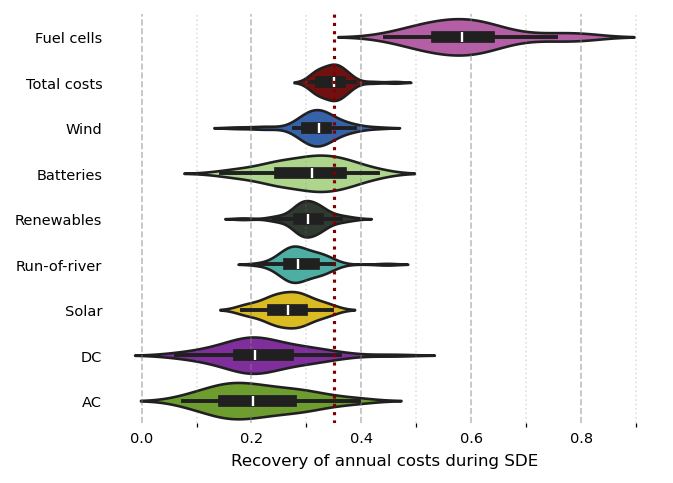

In [6]:
# tech_costs_sde.pdf# Create a violinplot with points for periods cost.

fig, ax = plt.subplots(1,1, figsize=(12*cm, 9*cm))


sns.violinplot(
    data=periods_cost[["fc", "costs", "wind", "batt",  "renew","ror", "solar", "links", "lines"]],
    ax=ax,
    palette=[colours["fuel_cells"], "maroon", colours["onwind"], colours["battery discharger"],  "#2F3C30",colours["ror"], colours["solar"], colours["DC"], colours["AC"]],
    orient="h",
)
# Add horizontal line with cost mean.
ax.axvline(periods_cost.costs.mean(), color="maroon", linestyle=":", label="Mean")
# Rename x-axis labels.
ax.set_yticklabels(["Fuel cells", "Total costs", "Wind", "Batteries",  "Renewables","Run-of-river", "Solar", "DC", "AC"], fontsize=7)
ax.set_xlabel("Recovery of annual costs during SDE", fontsize=8)

# Aesthetics
sns.despine(ax=ax, left=True, bottom=True)
# Add grid.
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# Add grids
ax.xaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
# Tick length
ax.tick_params(axis="both", length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/tech_costs_sde.pdf", bbox_inches="tight")


## S2: Dual costs

In [7]:
total_fc_dispatch = {}
for y in years:
    total_fc_dispatch[y] = (all_flex_detailed["fuel_cells"].loc[f"{y}-07-01":f"{y+1}-06-30"] * nodal_flex_p["H2 fuel cell"].loc[(slice(None), y)].sum())

(<Figure size 1062.99x1062.99 with 4 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

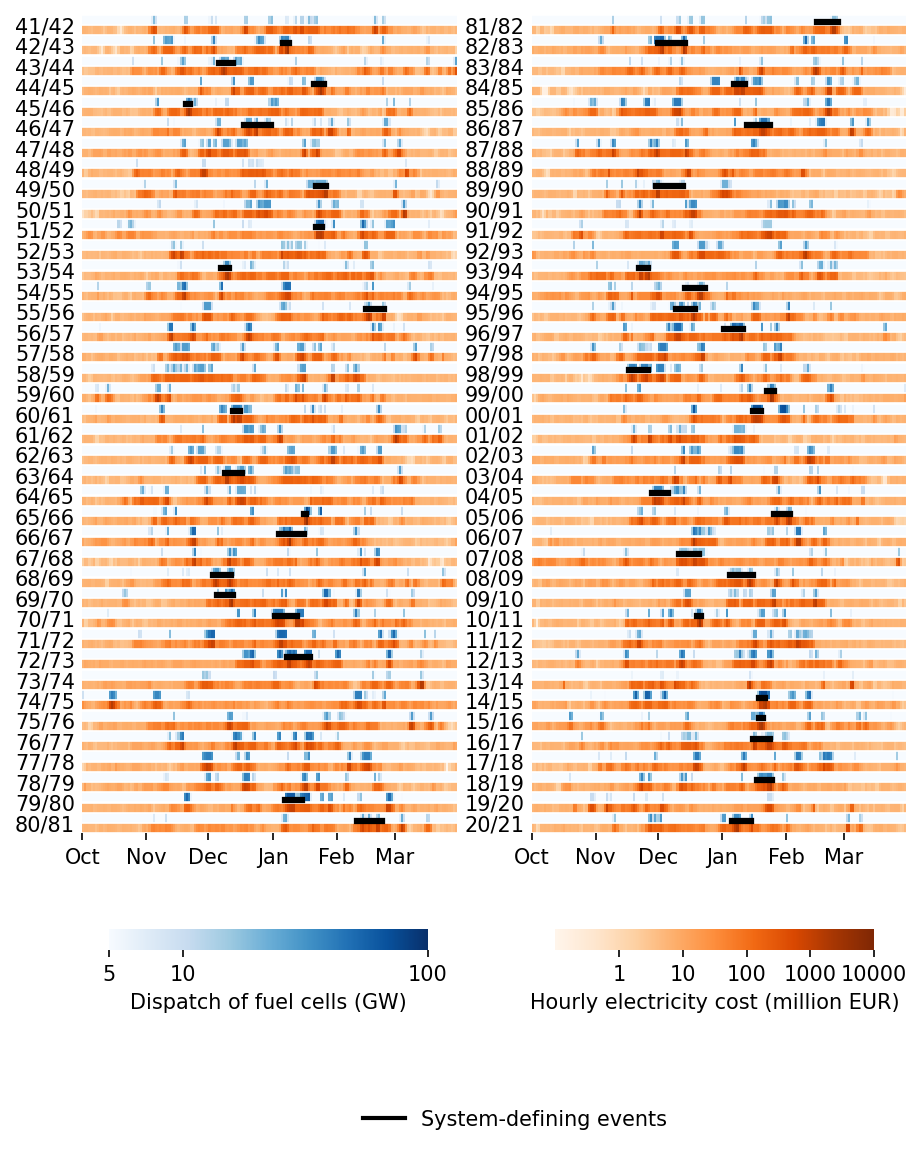

In [8]:
# HOURLY VALUE OF ELECTRICITY vs. HOURLY VALUE OF FUEL CELLS
plot_duals(
        periods, 
        years, 
        total_fc_dispatch, 
        total_system_costs, 
        mpl.colors.LogNorm(vmin=5, vmax=100, clip=True),
        mpl.colors.LogNorm(vmin=0.1, vmax=10000, clip=True), 
        "Blues",
        "Oranges",
        "Dispatch of fuel cells (GW)",
        "Hourly electricity cost (million EUR)",
        [5, 10, 100],
        [1, 10, 100, 1000, 10000],
        left_scaling = 1e-3,
        save_fig=True,
        path_str="./paper_plots/supp_mat/dual_costs_fc"
    )

## S11: Accumulated costs during winter

/tmp/ipykernel_82199/1234833428.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Fuel cells", "Total costs", "Wind", "Batteries",  "Renewables", "Run-of-river", "Solar", "DC", "AC"], fontsize=7)


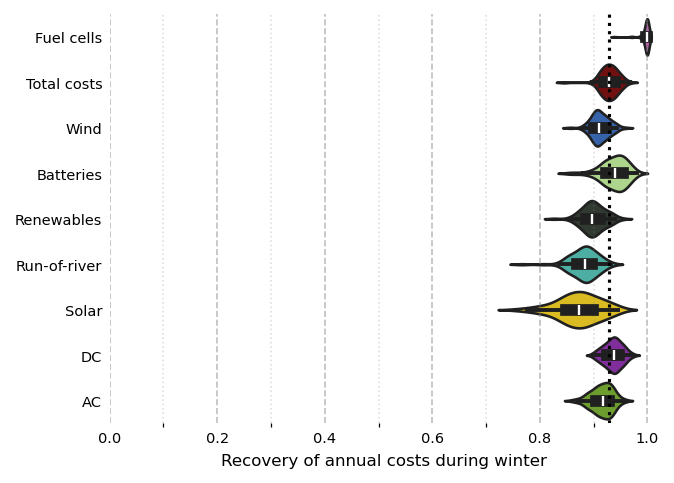

In [9]:
# Create a violinplot with points for periods cost.

fig, ax = plt.subplots(1,1, figsize=(12*cm, 9*cm))


sns.violinplot(
    data=winter_costs[["fc", "costs", "wind", "batt",  "renew", "ror", "solar", "links", "lines"]],
    ax=ax,
    palette=[colours["fuel_cells"], "maroon", colours["onwind"], colours["battery discharger"],  "#2F3C30", colours["ror"], colours["solar"], colours["DC"], colours["AC"]],
    orient="h",
)
# Add horizontal line with cost mean.
ax.axvline(winter_costs.costs.mean(), color="black", linestyle=":", label="Winter mean")
# Rename x-axis labels.
ax.set_yticklabels(["Fuel cells", "Total costs", "Wind", "Batteries",  "Renewables", "Run-of-river", "Solar", "DC", "AC"], fontsize=7)
ax.set_xlabel("Recovery of annual costs during winter", fontsize=8)

# Aesthetics
sns.despine(ax=ax, left=True, bottom=True)
# Add grid.
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# Add grids
ax.xaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
# Tick length
ax.tick_params(axis="both", length=0, labelsize=7)
ax.set_xlim(left=0)

plt.savefig("paper_plots/supp_mat/recovery_winter.pdf", bbox_inches="tight")


# Generation shares

In [10]:
winter_shares_df = pd.read_csv(f"{folder}/generation_winter_shares.csv", index_col=0)
periods_shares_df = pd.read_csv(f"{folder}/generation_periods_shares.csv", index_col=0)
annual_gen_shares_df = pd.read_csv(f"{folder}/generation_annual_shares.csv", index_col=0)
nov_feb_shares_df = pd.read_csv(f"{folder}/generation_nov_feb_shares.csv", index_col=0)

# Reorder columns:
winter_shares_df = winter_shares_df[["biomass", "nuclear", "ror", "battery discharger", "hydro", "PHS", "H2 fuel cell", "solar", "offwind", "onwind"]]
periods_shares_df = periods_shares_df[["biomass", "nuclear", "ror", "battery discharger", "hydro", "PHS", "H2 fuel cell", "solar", "offwind", "onwind"]]
annual_gen_shares_df = annual_gen_shares_df[["biomass", "nuclear", "ror", "battery discharger", "hydro", "PHS", "H2 fuel cell", "solar", "offwind", "onwind"]]
nov_feb_shares_df = nov_feb_shares_df[["biomass", "nuclear", "ror", "battery discharger", "hydro", "PHS", "H2 fuel cell", "solar", "offwind", "onwind"]]

## S3: SDEs

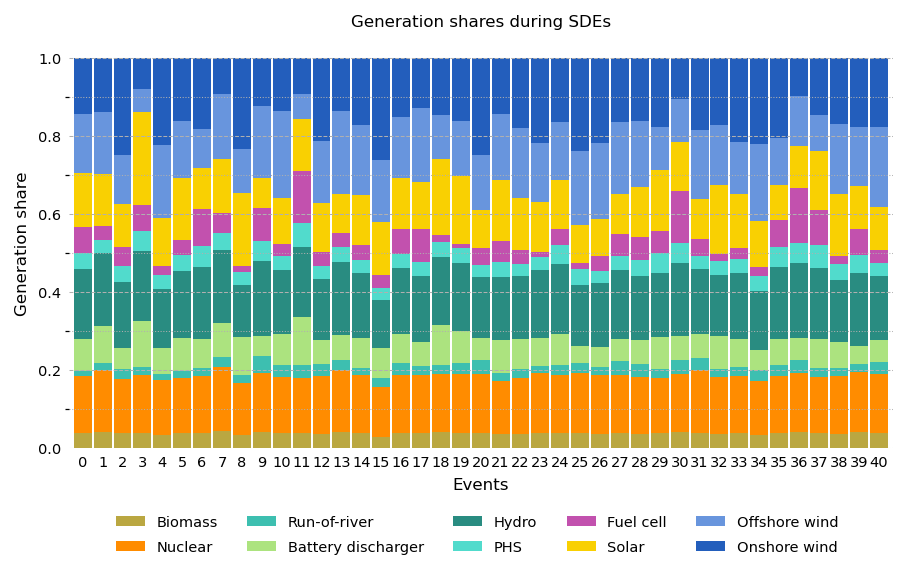

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18 * cm, 9 * cm))

periods_shares_df.plot.bar(stacked=True, width=0.9, color = [colours[i] for i in periods_shares_df.columns], legend=True, ax=ax)

# Aesthetics
ax.set_ylabel("Generation share", fontsize=8)
ax.set_xlabel("Events", fontsize=8)
ax.set_title("Generation shares during SDEs", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="both", which="major", length=0, labelsize=7,rotation=0)
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)

# Add legend with manual labels
handles, _ = ax.get_legend_handles_labels()
labels = ["Biomass", "Nuclear", "Run-of-river", "Battery discharger", "Hydro", "PHS", "Fuel cell", "Solar", "Offshore wind", "Onshore wind"]
ax.legend(handles=handles, labels=labels, ncol=5, loc="upper left", fontsize=7, bbox_to_anchor=(0.05, -0.15), borderaxespad=0.0, frameon=False, labelspacing=0.75)

fig.savefig("paper_plots/supp_mat/gen_share_sde.pdf", bbox_inches="tight")

## S4: Nov - Feb

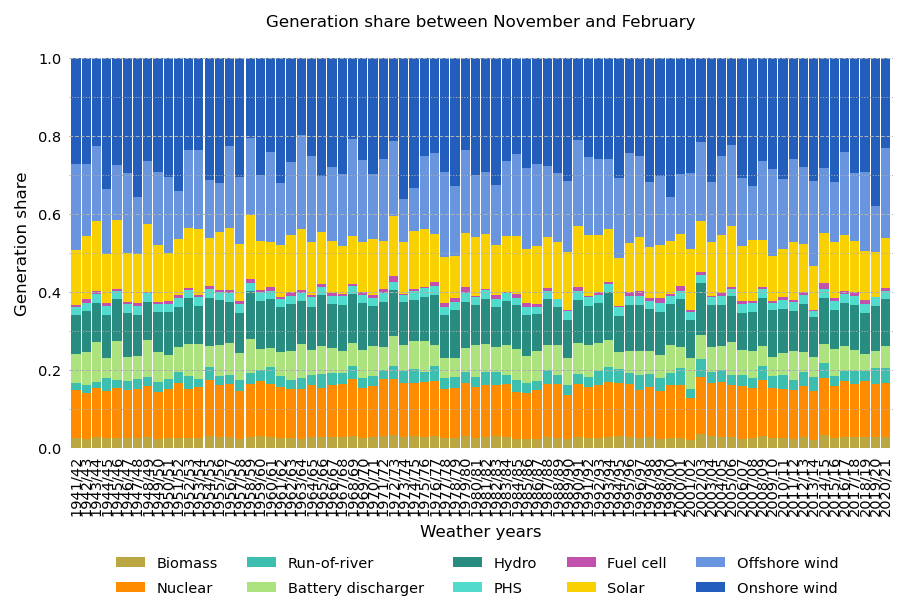

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18 * cm, 9 * cm))

nov_feb_shares_df.plot.bar(stacked=True, width=0.9, color = [colours[i] for i in nov_feb_shares_df.columns], legend=True, ax=ax)

# Aesthetics
ax.set_ylabel("Generation share", fontsize=8)
ax.set_xlabel("Weather years", fontsize=8)
ax.set_title("Generation share between November and February", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
ax.tick_params(axis="x", which="major", length=0, labelsize=7,rotation=90)
ax.set_xticklabels([f"{str(y)}/{str(y+1)[-2:]}" for y in years], rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)

# Add legend with manual labels
handles, _ = ax.get_legend_handles_labels()
labels = ["Biomass", "Nuclear", "Run-of-river", "Battery discharger", "Hydro", "PHS", "Fuel cell", "Solar", "Offshore wind", "Onshore wind"]
ax.legend(handles=handles, labels=labels, ncol=5, loc="upper left", fontsize=7, bbox_to_anchor=(0.05, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)
fig.savefig("paper_plots/supp_mat/gen_share_nov_feb.pdf", bbox_inches="tight", dpi=300)

## S5: Anomaly during SDE compared to Nov - Feb

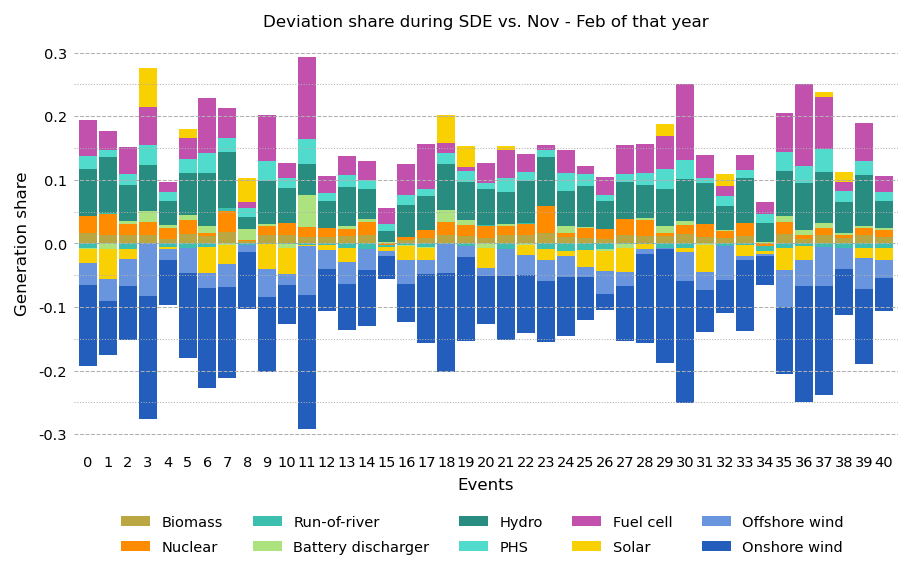

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(18 * cm, 9 * cm))

(periods_shares_df - pd.concat([nov_feb_shares_df.loc[get_net_year(periods.loc[i, "start"])] for i in periods.index], axis=1, ignore_index=True).T).plot.bar(stacked=True, width=0.9, color = [colours[i] for i in periods_shares_df.columns], legend=True, ax=ax)

# Aesthetics
ax.set_ylabel("Generation share", fontsize=8)
ax.set_xlabel("Events", fontsize=8)
ax.set_title("Deviation share during SDE vs. Nov - Feb of that year", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="both", which="both", length=0, labelsize=7,rotation=0)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)

# Add legend with manual labels
handles, _ = ax.get_legend_handles_labels()
labels = ["Biomass", "Nuclear", "Run-of-river", "Battery discharger", "Hydro", "PHS", "Fuel cell", "Solar", "Offshore wind", "Onshore wind"]
ax.legend(handles=handles, labels=labels, ncol=5, loc="upper left", fontsize=7, bbox_to_anchor=(0.05, -0.15), borderaxespad=0.0, frameon=False, labelspacing=0.75)
fig.savefig("paper_plots/supp_mat/gen_diff_sde_nov_feb.pdf", bbox_inches="tight")


## S6: Annual

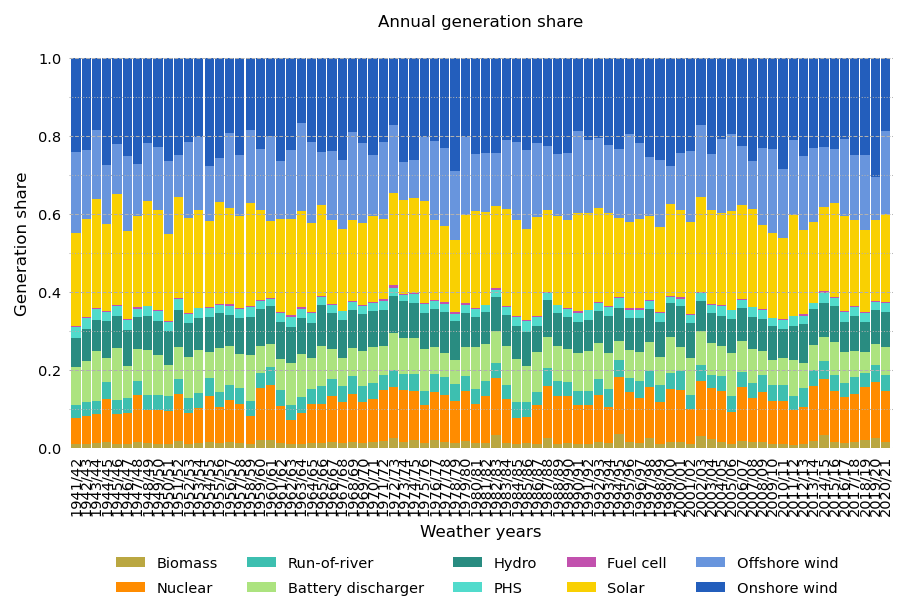

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18 * cm, 9 * cm))

annual_gen_shares_df.plot.bar(stacked=True, width=0.9, color = [colours[i] for i in annual_gen_shares_df.columns], legend=True, ax=ax)

# Aesthetics
ax.set_ylabel("Generation share", fontsize=8)
ax.set_xlabel("Weather years", fontsize=8)
ax.set_title("Annual generation share", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
ax.tick_params(axis="x", which="major", length=0, labelsize=7,rotation=90)
ax.set_xticklabels([f"{str(y)}/{str(y+1)[-2:]}" for y in years], rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)

# Add legend with manual labels
handles, _ = ax.get_legend_handles_labels()
labels = ["Biomass", "Nuclear", "Run-of-river", "Battery discharger", "Hydro", "PHS", "Fuel cell", "Solar", "Offshore wind", "Onshore wind"]
ax.legend(handles=handles, labels=labels, ncol=5, loc="upper left", fontsize=7, bbox_to_anchor=(0.05, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)

fig.savefig("paper_plots/supp_mat/annual_gen_share.pdf", bbox_inches="tight")

## S7: Peak hour of SDE

In [52]:
peak_gen = pd.read_csv(f"{folder}/peak_gen.csv", index_col=0, parse_dates=True)

/tmp/ipykernel_82199/2501454591.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


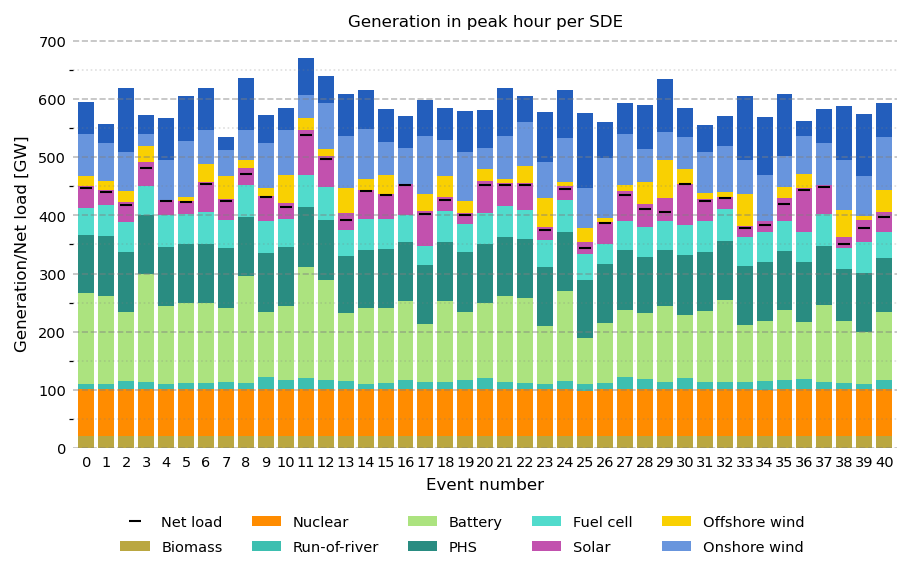

In [53]:
# Plot a stacked bar plot of the peak generation per technology for each event.
fig, ax = plt.subplots(1,1, figsize = (18*cm, 9*cm))
reindexed_peak_gen = peak_gen.reset_index()[["biomass", "nuclear", "ror", "battery discharger", "hydro", "PHS", "H2 fuel cell", "solar", "offwind", "onwind"]]


reindexed_peak_gen.plot.bar(
    stacked=True,
    ax=ax,
    width = 0.8,
    color=[colours[tech] for tech in reindexed_peak_gen.columns],
)
# Draw a red line for the net load.
ax.plot(reindexed_peak_gen.index, peak_gen["net load"], color="black", linewidth=0, marker = "_", label="Net load")

ax.set_title("Generation in peak hour per SDE", fontsize=8)

# Aesthetics
ax.set_xlabel("Event number", fontsize=8)
ax.set_ylabel("Generation/Net load [GW]", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)

# Add grid
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
# Add grids
ax.yaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
ax.tick_params(axis="both", length=0, labelsize=7,rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
# Rename labels manually
labels = ["Net load", "Biomass", "Nuclear", "Run-of-river", "Battery", "PHS", "Fuel cell", "Solar", "Offshore wind", "Onshore wind"]
ax.legend(handles, labels, bbox_to_anchor=(0.05, -0.15), loc=2, ncol=5, borderaxespad=0.0, frameon=False, labelspacing=0.75, fontsize=7)
fig.savefig("paper_plots/supp_mat/peak_gen.pdf", bbox_inches="tight")


# Duration curves

## S8: Flexibility capacities

In [16]:
firm_flex_df = pd.read_csv(f"{folder}/firm_flex_df.csv", index_col=0)

/tmp/ipykernel_82199/1335355550.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
/tmp/ipykernel_82199/1335355550.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
/tmp/ipykernel_82199/1335355550.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


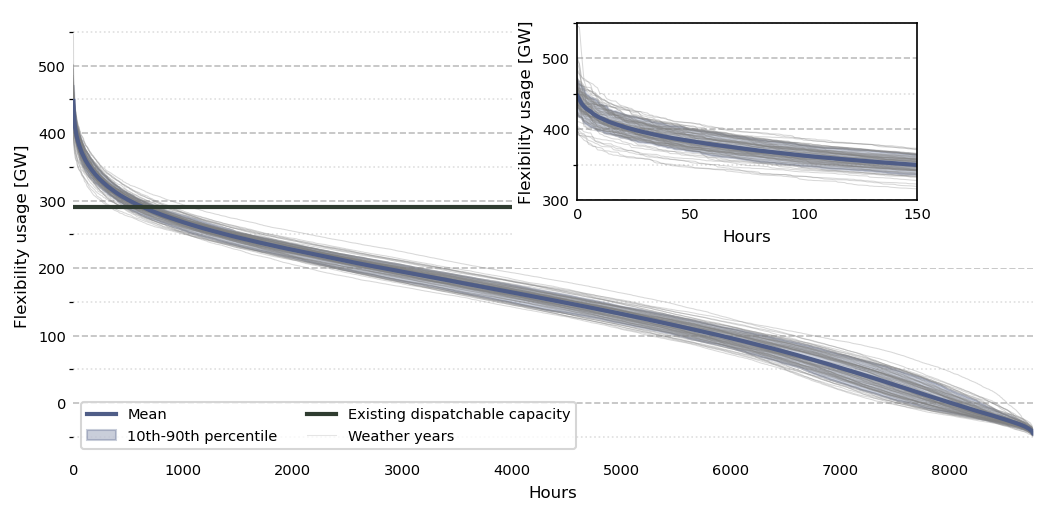

In [17]:
# Create main plot
fig, ax = plt.subplots(figsize=(18*cm, 9*cm))

# Plot individual load duration curves
for col in firm_flex_df.columns:
    sns.lineplot(data=firm_flex_df[col], ax=ax, color="grey", alpha=0.3, linewidth=0.5)

# Plot mean load duration curve
sns.lineplot(data=firm_flex_df.mean(axis="columns"), ax=ax, color="#4F5D87", linewidth=2, label="Mean", legend=False)

# Plot fill between 10th and 90th percentiles
ax.fill_between(
    firm_flex_df.index,
    firm_flex_df.quantile(0.1, axis=1),
    firm_flex_df.quantile(0.9, axis=1),
    color=colours_midnights[1],
    alpha=0.3,
    label="10th-90th percentile"
)

# Draw a horizontal line at 291 GW for existing dispatch capacities
ax.axhline(y=291, color="#2F3C30", linestyle='-', linewidth=2, alpha=1, label="Existing dispatchable capacity")

# Main plot settings
ax.set_ylabel("Flexibility usage [GW]", fontsize=8)
ax.set_xlabel("Hours", fontsize=8)
ax.set_xlim(0, 8760)

# Aesthetics: remove spines, ticks (keeping labels), add grid
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="both", length=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
# Add grid
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
ax.tick_params(axis="both", length=0, labelsize=7)



# Add rectangle to highlight the area of interest
rect = Rectangle ((4000,200), 4760, 400, linewidth=1, edgecolor='none', facecolor='white', linestyle='-', zorder=5)
ax.add_patch(rect)


# Inset: Zoom in from 0 to 150 hours
ax_inset = fig.add_axes([0.55, 0.608, 0.32, 0.334], )  # [left, bottom, width, height]
for col in firm_flex_df.columns:
    sns.lineplot(data=firm_flex_df[col], ax=ax_inset, color="grey", alpha=0.3, linewidth=0.5, legend=False)

# Plot mean load duration for inset
sns.lineplot(data=firm_flex_df.mean(axis="columns"), ax=ax_inset, color="#4F5D87", linewidth=2, label ="Mean", legend=False)
ax_inset.fill_between(
    firm_flex_df.index,
    firm_flex_df.quantile(0.1, axis=1),
    firm_flex_df.quantile(0.9, axis=1),
    color=colours_midnights[1],
    alpha=0.3
)

# Inset settings
ax_inset.set_xlim(0, 150)
ax_inset.set_ylim(300,550)  
ax_inset.set_xticks([0, 50, 100, 150])
ax_inset.set_yticks([300,350,400,450,500,550])
ax_inset.set_xticklabels(ax_inset.get_xticklabels(), fontsize=7)
ax_inset.set_yticklabels(ax_inset.get_yticklabels(), fontsize=7)
# Add grid.
ax_inset.yaxis.set_major_locator(MultipleLocator(100))
ax_inset.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_inset.yaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
ax_inset.yaxis.set_minor_locator(AutoMinorLocator(2))
ax_inset.yaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
ax_inset.tick_params(axis="both", length=0, labelsize=7)
ax_inset.set_ylabel("Flexibility usage [GW]", fontsize=8)
ax_inset.set_xlabel("Hours", fontsize=8)

handles, labels = ax.get_legend_handles_labels()
# Add one lineplot for the weather years manually
handles.append(Line2D([0], [0], color="grey", alpha=0.2, linewidth=0.5, label="Weather years"))
labels.append("Weather years")
ax.legend(labels=labels, handles=handles, loc = "lower left", fontsize=7, ncol=2)

# Display the plot
plt.tight_layout()

plt.savefig("paper_plots/supp_mat/flex_usage_duration.pdf", bbox_inches="tight")


## S9: Fuel cells

In [18]:
gen_fc_df = pd.read_csv(f"{folder}/gen_fc_df.csv", index_col=0)

/tmp/ipykernel_82199/1758810283.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/tmp/ipykernel_82199/1758810283.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
/tmp/ipykernel_82199/1758810283.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


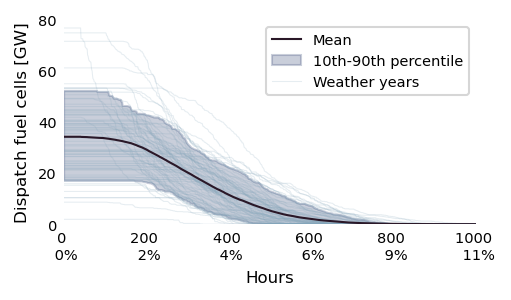

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9 * cm, 4.5 * cm))

# Plot individual load duration curves
for col in gen_fc_df.columns:
    sns.lineplot(data=gen_fc_df[col], ax=ax, color=colours_midnights[2], alpha=0.2, linewidth=0.5, legend=False)

# Plot mean load duration curve
sns.lineplot(data=gen_fc_df.mean(axis="columns"), ax=ax, color=colours_midnights[0], linewidth=1, label="Mean")

# Plot fill between 10th and 90th percentiles
ax.fill_between(
    gen_fc_df.index,
    gen_fc_df.quantile(0.1, axis=1),
    gen_fc_df.quantile(0.9, axis=1),
    color=colours_midnights[1],
    alpha=0.3,
    label="10th-90th percentile"
)

ax.set_ylabel("Dispatch fuel cells [GW]", fontsize=8)
ax.set_xlabel("Hours", fontsize=8)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 80)
# Add for each of the xticklabels and yticklabels the capacity factor (relative to 194 GW installed capacity) as well as the duration relative to 8760 hours.
xticklabels = [f"{i:.0f} \n {int(i/8760*100)}%" for i in ax.get_xticks()]
ax.set_xticklabels(xticklabels)

# Get labels and handles
handles, labels = ax.get_legend_handles_labels()
# Add one lineplot for the weather years manually
handles.append(Line2D([0], [0], color=colours_midnights[2], alpha=0.2, linewidth=0.5, label="Weather years"))
labels.append("Weather years")
ax.legend(labels=labels, handles=handles, fontsize=7)

# Remove x and y ticks; labels with fontsize 7
ax.tick_params(axis="both", length=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

sns.despine(ax=ax, left=True, bottom=True)
plt.show()
fig.savefig("paper_plots/supp_mat/fc_dispatch_duration.pdf", bbox_inches="tight")

## Capacities

## S10: Battery discharge and fuel cells

In [20]:
s_caps = pd.read_csv(f"{folder}/s_caps.csv", index_col=0)

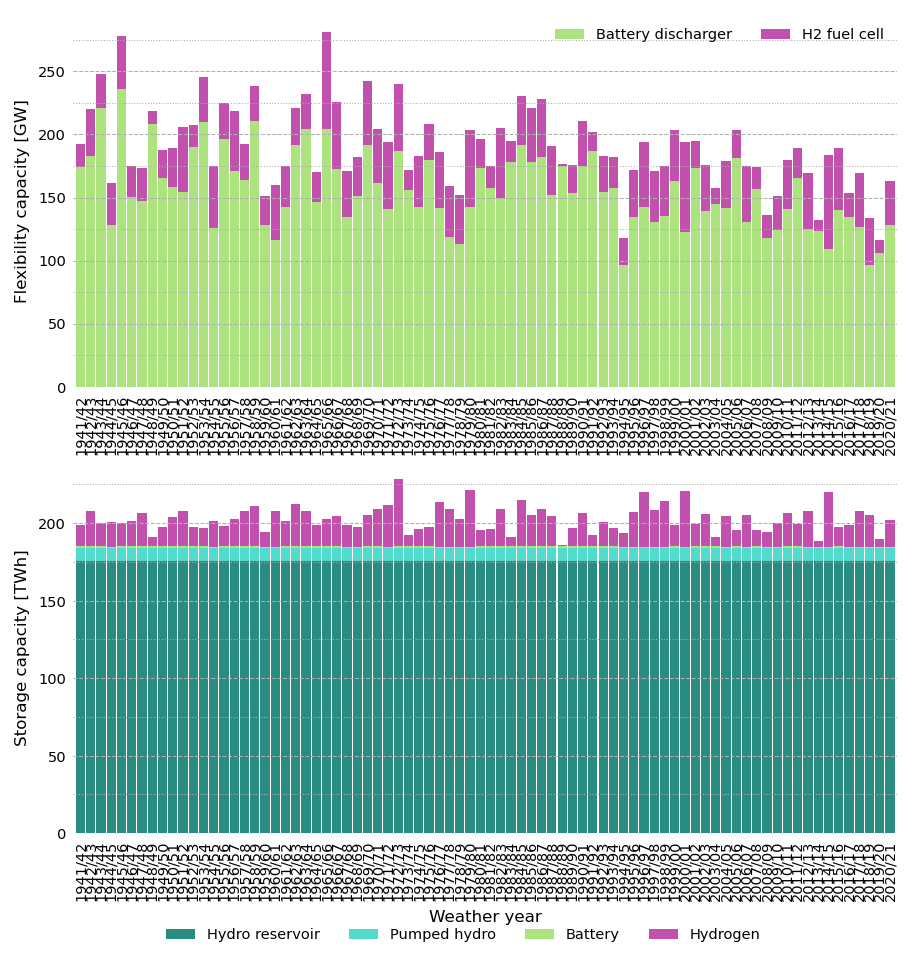

In [21]:
df_system_flex = system_flex_p.unstack(level=0)
# Reorder df_system_flex to be of the form baseload, and then the order of how we dispatch during extreme events.
df_system_flex = df_system_flex[["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]]

fig, axs= plt.subplots(2,1, figsize=(18*cm, 18*cm))
# Plot a stacked bar plot for all system flexibility capacities. Set the level 0 of the index to be columns and level 1 to be the index.
ax = axs[0]
df_system_flex[["battery discharger", "H2 fuel cell"]].plot(
    kind="bar", stacked=True, ax=ax,
    color=[colours[t] for t in df_system_flex[["battery discharger", "H2 fuel cell"]].columns],
    width=0.9, zorder=0
)


ax.set_ylabel("Flexibility capacity [GW]", fontsize=8)
ax.set_xlabel("Weather year", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
ax.tick_params(axis="x", which="major", length=0, labelsize=7,rotation=90)
ax.set_xticklabels([f"{str(y)}/{str(y+1)[-2:]}" for y in years], rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)
pretty_labels = ["Battery discharger", "H2 fuel cell"]
ax.legend(pretty_labels,loc="upper right", frameon=False, labelspacing=0.75, ncols = 2, fontsize=7)

ax = axs[1]
# in TWh
(s_caps[["hydro_e", "PHS_e", "batt_e", "H2_e"]]/1e3).plot(
    kind="bar", stacked=True, ax=ax,
    color=[colours[t] for t in df_system_flex[["hydro", "PHS", "battery discharger", "H2 fuel cell"]].columns],
    width=0.9, zorder=0
)
ax.legend(pretty_labels,loc="upper right", bbox_to_anchor=(0.9, -0.2), frameon=False, labelspacing=0.75, ncols = 7)
ax.set_ylabel("Storage capacity [TWh]", fontsize=8)
ax.set_xlabel("Weather year", fontsize=8)
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
ax.tick_params(axis="x", which="major", length=0, labelsize=7,rotation=90)
ax.set_xticklabels([f"{str(y)}/{str(y+1)[-2:]}" for y in years], rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=1)

pretty_labels = ["Hydro reservoir", "Pumped hydro", "Battery", "Hydrogen"]
ax.legend(pretty_labels,bbox_to_anchor = (0.85, -0.22), frameon=False, labelspacing=0.75, ncols = 4, fontsize=7)

plt.savefig("paper_plots/supp_mat/flex_caps.pdf", bbox_inches="tight")
plt.show()

# Sensitivities

## S20: Number of SDEs across configurations

In [22]:
sens_config_name = "stressful-weather-sensitivities"
cost_thresholds = [30,50, 100]
dict_names = [f"new_store_1941-2021_{c}bn_12-336h" for c in cost_thresholds]

sens_config, sens_scenario_def, years, sens_opt_networks = load_opt_networks(sens_config_name, load_networks=regenerate_data)

sens_periods = load_sens_periods(sens_config, cost_thresholds)
# Compute the number of system-defining events per sensitivity scenario
n_events = {cost: {
    scenar: len(sens_periods[cost][scenar]) for scenar in sens_periods[cost].keys()} for cost in cost_thresholds}
nb_events = pd.concat({cost: pd.DataFrame(n_events[cost], index=["n_events"]).T for cost in cost_thresholds}, axis=1)

/tmp/ipykernel_82199/1752297185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_helper[50] -= df_helper[100]
/tmp/ipykernel_82199/1752297185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_helper[30] -= (df_helper[100] + df_helper[50])
/tmp/ipykernel_82199/1752297185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

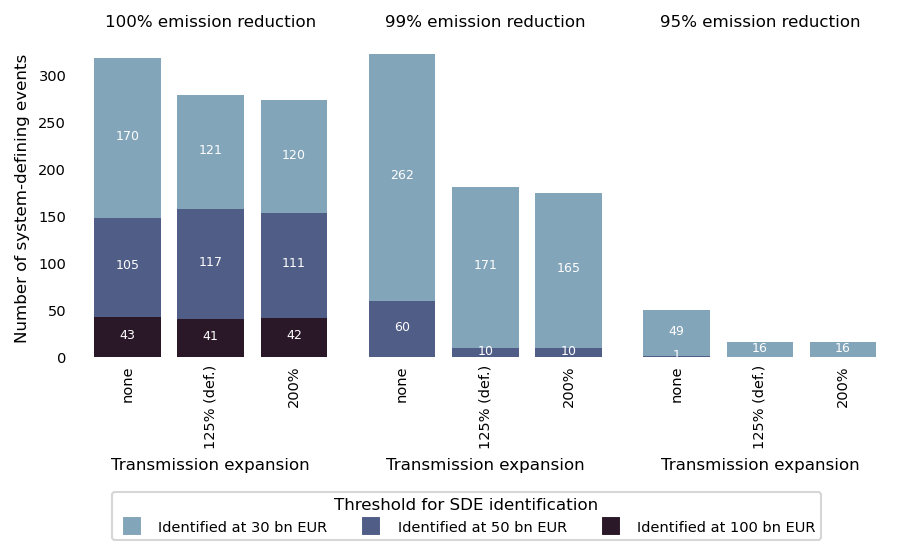

In [23]:
fig, axs = plt.subplots(1,3, figsize=(18*cm, 7*cm), sharey=True, gridspec_kw={"wspace": 0.0})

# Net-zero scenarios
for ax, red, reduction in zip(axs, ["Co2L0.0", "Co2L0.01", "Co2L0.05"], ["100%", "99%", "95%"]):
    ax.set_title(f"{reduction} emission reduction", fontsize=8)
    df_helper = nb_events.loc[(90, slice(None), red)]
    df_helper[50] -= df_helper[100]
    df_helper[30] -= (df_helper[100] + df_helper[50])
    df_helper = df_helper[[100, 50, 30]]
    df_helper.plot.bar(ax=ax, stacked=True, color=colours_midnights, width=0.8, legend=False)
    for container in ax.containers:
        labels = [f"{int(v.get_height())}" if v.get_height() > 0 else "" for v in container]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=6, color="white", padding=1)
    del df_helper

    # Aesthetics
    ax.set_xlabel("Transmission expansion", fontsize=8)
    ax.set_ylabel("Number of system-defining events", fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=7, length=0)
    ax.set_xticklabels(["none", "125% (def.)", "200%"], fontsize=7)
    sns.despine(ax=ax, left=True, bottom=True)

legend_elements = [Line2D([0], [0], marker='s', color='w', label='Identified at 30 bn EUR', markerfacecolor='#83A5BA', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Identified at 50 bn EUR', markerfacecolor='#4F5D87', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Identified at 100 bn EUR', markerfacecolor='#2A1828', markersize=10)]
axs[2].legend(handles=legend_elements, bbox_to_anchor=(0.75, -0.4), ncol=3, fontsize=7,title="Threshold for SDE identification", title_fontsize=8)

plt.savefig("paper_plots/supp_mat/sensitivity_number.pdf", bbox_inches="tight")


   

## Transmission sensitivities
### S12: Figure 2 with c1.0

In [24]:
c1_config_name = "stressful-weather-sensitivities"
c1_config, c1_scenario_def, years, c1_opt_networks = load_opt_networks(config_name, config_str = "base_s_90_elec_lc1.0_Co2L0.0", load_networks=regenerate_data)

c1_periods = load_periods(c1_config)

# Load all data we might need that is pre-generated in `generate_data_for_analysis.py`.
c1_folder = f"./processing_data/{c1_config_name}"

# Load: net load, total load, winter load
c1_net_load = pd.read_csv(f"{c1_folder}/net_load.csv", index_col=0, parse_dates=True)

c1_nodal_load = pd.read_csv(f"{c1_folder}/nodal_load.csv", index_col=0, parse_dates=True)

# Costs: nodal prices, total electricity/storage/fuel cell costs
c1_all_prices = pd.read_csv(f"{c1_folder}/all_prices.csv", index_col=0, parse_dates=True)
c1_total_costs_df = pd.read_csv(f"{c1_folder}/total_costs.csv", index_col=[0,1])
c1_total_costs = {}
for year in years:
    df = c1_total_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    c1_total_costs[year] = df
c1_total_storage_costs_df = pd.read_csv(f"{c1_folder}/total_storage_costs.csv", index_col=[0,1])
c1_total_fc_costs_df = pd.read_csv(f"{c1_folder}/total_fc_costs.csv", index_col=[0,1])


## SDEs
# Stats for storage behaviour
c1_stores_periods = pd.read_csv(f"{c1_folder}/stores_periods.csv", index_col=0)

# Stats for clustering: net load peak hour, highest net load, avg net load, energy deficit, h2 discharge, max fc discharge, avg rel load, wind cf, wind anom, annual cost
c1_stats_periods = pd.read_csv(f"{c1_folder}/stats_periods.csv", index_col=0)

## FLEXIBILITY
# System: detailed
c1_all_flex_detailed = pd.read_csv(f"{c1_folder}/all_flex_detailed.csv", index_col=0, parse_dates=True)
c1_avg_flex_detailed = pd.read_csv(f"{c1_folder}/avg_flex_detailed.csv", index_col=0, parse_dates=True)
c1_periods_flex_detailed = pd.read_csv(f"{c1_folder}/periods_flex_detailed.csv", index_col=0, parse_dates=True)
c1_periods_anomaly_flex_detailed = pd.read_csv(f"{c1_folder}/periods_anomaly_flex_detailed.csv", index_col=0, parse_dates=True)
c1_periods_peak_flex_detailed = pd.read_csv(f"{c1_folder}/periods_peak_flex_detailed.csv", index_col=0, parse_dates=True)
c1_periods_peak_anomaly_flex_detailed = pd.read_csv(f"{c1_folder}/periods_peak_anomaly_flex_detailed.csv", index_col=0, parse_dates=True)


## SYSTEM VALUES
c1_all_system_anomaly = pd.read_csv(f"{c1_folder}/all_system_anomaly.csv", index_col=0, parse_dates=True)
c1_all_used_flexibility = pd.read_csv(f"{c1_folder}/all_used_flexibility.csv", index_col=0, parse_dates=True)
c1_all_flex_anomaly = pd.read_csv(f"{c1_folder}/all_flex_anomaly.csv", index_col=0, parse_dates=True)

# Nodal
c1_nodal_flex_p = pd.read_csv(f"{c1_folder}/nodal_flex_p.csv", index_col=[0,1])
c1_nodal_flex_u = xr.open_dataset(f"{c1_folder}/nodal_flex_u.nc")


## AVERAGES
# Load the means, anomalies.
load_means = pd.read_csv("../pypsa-eur/results/means/load_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
solar_means = pd.read_csv("../pypsa-eur/results/means/solar_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
wind_means = pd.read_csv("../pypsa-eur/results/means/wind_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)

# Capacity factors and capacities.
c1_wind_cf = xr.open_dataset(f"{c1_folder}/wind_cf.nc").to_dataframe()
c1_solar_cf = xr.open_dataset(f"{c1_folder}/solar_cf.nc").to_dataframe()
c1_wind_caps = pd.read_csv(f"{c1_folder}/wind_caps.csv", index_col=0)
c1_solar_caps = pd.read_csv(f"{c1_folder}/solar_caps.csv", index_col=0)

# Load laod.
c1_total_load = pd.read_csv(f"{c1_folder}/total_load.csv", index_col=0, parse_dates=True)
c1_nodal_load = pd.read_csv(f"{c1_folder}/nodal_load.csv", index_col=0, parse_dates=True)

# Load onshore and offshore regions for shapefile.
onshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_onshore_base_s_90.geojson")
offshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_offshore_base_s_90.geojson")



# Calculate nodal net load.
c1_nodal_net_load = {}
for year in years:
    load = c1_nodal_load.loc[f"{year}-07-01":f"{year+1}-06-30"].copy()
    solar_prod = solar_caps[str(year)] * solar_cf[f"{year}-07-01":f"{year+1}-06-30"]
    wind_prod = wind_caps[str(year)] * wind_cf[f"{year}-07-01":f"{year+1}-06-30"]
    solar_prod.columns = n.generators.loc[solar_prod.columns].bus.values
    solar_prod = solar_prod.groupby(solar_prod.columns, axis=1).sum().round(0)
    wind_prod.columns = n.generators.loc[wind_prod.columns].bus.values
    wind_prod = wind_prod.groupby(wind_prod.columns, axis=1).sum().round(0)
    c1_nodal_net_load[year] = load - (solar_prod + wind_prod)
c1_nodal_net_load = pd.concat(c1_nodal_net_load.values(), axis=0)

c1_net_load_means = average_across_years(c1_nodal_net_load, years)

# Calculate all nodal costs.
c1_nodal_costs = c1_all_prices * c1_nodal_load

c1_fc_discharge = {}
for year in years:
    df_caps = c1_nodal_flex_p["H2 fuel cell"].unstack()[year].T
    df_cf = c1_nodal_flex_u["H2 fuel cell"].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
    c1_fc_discharge[year] = (df_cf * df_caps).round(1)

c1_fc_discharge_df = pd.concat(c1_fc_discharge.values(), axis=0)

c1_dispatch_flex = {}
for year in years:
    c1_dispatch_flex[year] = pd.DataFrame(0, columns = c1_nodal_flex_p.index.levels[0], index = pd.date_range(f"{year}-07-01", f"{year+1}-06-30 23:00", freq="h")).fillna(0)
    for tech in ["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]:
        df_caps = nodal_flex_p[tech].unstack()[year].T
        df_cf = nodal_flex_u[tech].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
        c1_dispatch_flex[year] += (df_cf * df_caps).fillna(0).round(1)

c1_dispatch_flex_df = pd.concat(c1_dispatch_flex.values(), axis=0)

c1_rel_dispatch = {}
for year in years:
    c1_rel_dispatch[year] = pd.DataFrame(0, columns = c1_nodal_flex_p.index.levels[0], index = pd.date_range(f"{year}-07-01", f"{year+1}-06-30 23:00", freq="h")).fillna(0)
    capacities = pd.DataFrame(0,columns=c1_nodal_flex_p.index.levels[0], index=["caps"])
    for tech in ["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]:
        df_caps = c1_nodal_flex_p[tech].unstack()[year].T
        df_cf = c1_nodal_flex_u[tech].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
        c1_rel_dispatch[year] += (df_cf * df_caps).fillna(0).round(1)
        capacities.loc["caps"] += df_caps
    c1_rel_dispatch[year] = c1_rel_dispatch[year]/capacities.loc["caps"]

c1_rel_flex_df = pd.concat(c1_rel_dispatch.values(), axis=0)

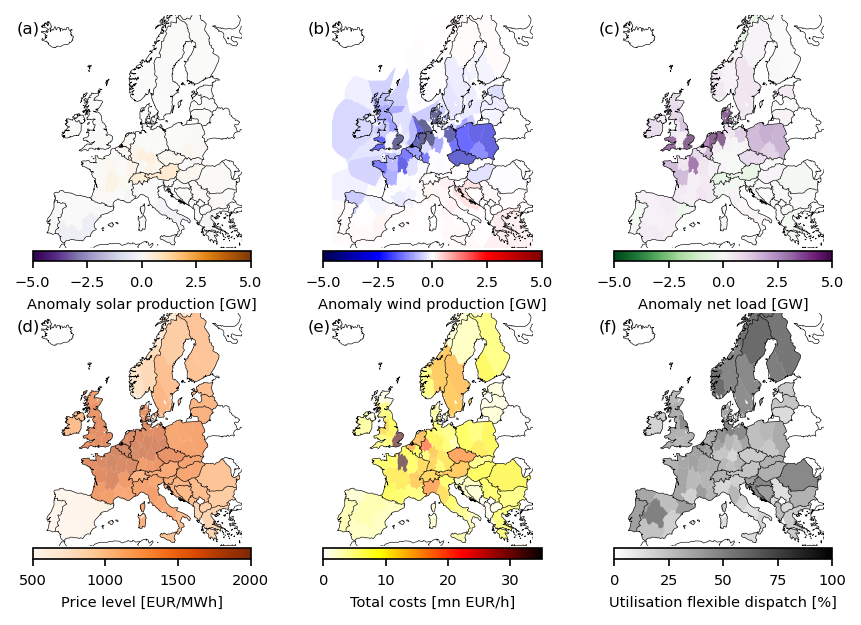

In [25]:
# Plot composite grid.
projection = ccrs.LambertConformal(central_longitude=10, central_latitude=50)

fig, axs = plt.subplots(2,3, figsize = (18*cm, 12*cm), subplot_kw={"projection": projection, "frame_on": False})

# Solar
ax = axs[0,0]
ax.text(-0.12, 0.92, "(a)", transform=ax.transAxes, fontsize=8)
plot_anomalies(
    "solar",
    n,
    cmap=mpl.cm.PuOr_r,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=c1_periods,
    caps=c1_solar_caps,
    cfs=c1_solar_cf,
    means=solar_means,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Anomaly solar production [GW]",
    scaling_factor = 1e-3,
)
# Wind
ax = axs[0,1]
ax.text(-0.12, 0.92, "(b)", transform=ax.transAxes, fontsize=8)
plot_anomalies(
    "wind",
    n,
    cmap=mpl.cm.seismic,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=c1_periods,
    caps=c1_wind_caps,
    cfs=c1_wind_cf,
    means=wind_means,
    ax = ax,
    projection = projection,
    offshore_regions=offshore_regions,
    cbar = True,
    cbar_label = "Anomaly wind production [GW]",
    scaling_factor = 1e-3,
)
# # Load
# ax = axs[0,2]
# fake_caps = pd.DataFrame(index = nodal_net_load.columns, columns = wind_caps.columns)
# fake_caps = fake_caps.fillna(1)
# plot_anomalies(
#     "load",
#     n,
#     cmap=mpl.cm.RdBu,
#     norm = mpl.colors.Normalize(vmin=-500, vmax=500),
#     regions=onshore_regions,
#     periods=periods,
#     caps=fake_caps,
#     cfs=nodal_load,
#     means=load_means,
#     ax = ax,
#     projection = projection,
# )
# Net load
ax = axs[0,2]
ax.text(-0.12, 0.92, "(c)", transform=ax.transAxes, fontsize=8)
fake_caps = pd.DataFrame(index = c1_nodal_net_load.columns, columns = wind_caps.columns)
fake_caps = fake_caps.fillna(1)
plot_anomalies(
    "net_load",
    n,
    cmap=mpl.cm.PRGn_r,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=c1_periods,
    caps=fake_caps,
    cfs=c1_nodal_net_load,
    means=c1_net_load_means,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Anomaly net load [GW]",
    scaling_factor = 1e-3,
)

# Price
ax = axs[1,0]
ax.text(-0.12, 0.92, "(d)", transform=ax.transAxes, fontsize=8)
plot_prices(
    n,
    cmap=mpl.cm.Oranges,
    norm = mpl.colors.Normalize(vmin=500, vmax=2000),
    regions=onshore_regions,
    nodal_prices = c1_all_prices,
    periods=c1_periods,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Price level [EUR/MWh]",
)
# Hourly costs
ax = axs[1,1]
ax.text(-0.12, 0.92, "(e)", transform=ax.transAxes, fontsize=8)
plot_total_costs(
    n,
    cmap=mpl.cm.hot_r,
    norm = mpl.colors.Normalize(vmin=0, vmax=35),
    regions=onshore_regions,
    nodal_costs = c1_nodal_costs/1e6,
    periods=c1_periods,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Total costs [mn EUR/h]",
)
# Fuel cell
ax = axs[1,2]
ax.text(-0.12, 0.92, "(f)", transform=ax.transAxes, fontsize=8)
# plot_fc_util(
#     n,
#     cmap=mpl.cm.gist_gray_r,
#     norm = mpl.colors.LogNorm(vmin=0.6, vmax=0.8),
#     regions=onshore_regions,
#     periods=periods,
#     fc_flex = nodal_flex_u["H2 fuel cell"].to_pandas().T,
#     ax = ax,
#     projection = projection,
#     cbar = True,
#     cbar_label = "Fuel cell utilisation",
# )
plot_fc_util(
    n,
    cmap=mpl.cm.gist_gray_r,
    norm = mpl.colors.Normalize(vmin=0, vmax=100),
    regions=onshore_regions,
    periods=c1_periods,
    fc_flex = c1_rel_flex_df,
    projection = projection,
    cbar = True,
    cbar_label = "Utilisation flexible dispatch [%]",
    ax=ax,
    scaling_factor = 100,
)

fig.savefig("paper_plots/supp_mat/affected_areas_no_transmission.pdf", bbox_inches="tight")

## Gas sensitivities
### S21: Duration curves of fuel cells vs gas

In [26]:
# if regenerate_data:
#     config_gas, scenario_def_gas, years, opt_networks_gas = load_opt_networks("stressful-weather-sensitivities", config_str = "base_s_90_elec_lc1.25_Co2L0.01", load_networks=regenerate_data)

#     gas_i = opt_networks_gas[1941].generators[opt_networks_gas[1941].generators.carrier.isin(["CCGT", "OCGT"])].index
#     gen_gas_df = pd.DataFrame(index = range(8760))
#     for year, n in opt_networks_gas.istems():
#             gen_gas_df[year] = n.generators_t.p[gas_i].sum(axis=1).sort_values(ascending=False).values
#     gen_gas_df = (gen_gas_df/1e3).round(1)
#     gen_gas_df.to_csv("sensitivity_analysis/gen_gas_df.csv")



In [27]:
gen_gas_df = pd.read_csv("sensitivity_analysis/gen_gas_df.csv", index_col=0)

/tmp/ipykernel_82199/1018559669.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)
/tmp/ipykernel_82199/1018559669.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


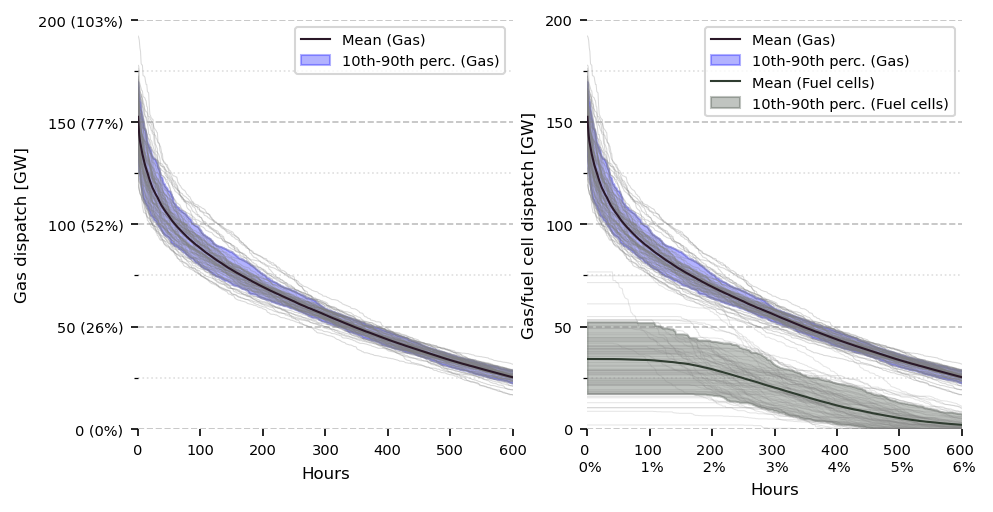

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(18 * cm, 9 * cm))

for ax in axs:
    # Plot individual load duration curves
    for col in gen_gas_df.columns:
        sns.lineplot(data=gen_gas_df[col], ax=ax, color="grey", alpha=0.3, linewidth=0.5)

    # Plot mean load duration curve
    sns.lineplot(data=gen_gas_df.mean(axis="columns"), ax=ax, color="#2A1828", linewidth=1, label="Mean (Gas)")

    # Plot fill between 10th and 90th percentiles
    ax.fill_between(
        gen_gas_df.index,
        gen_gas_df.quantile(0.1, axis=1),
        gen_gas_df.quantile(0.9, axis=1),
        color="blue",
        alpha=0.3,
        label="10th-90th perc. (Gas)"
    )
    if ax == axs[1]:
        for col in gen_fc_df.columns:
            sns.lineplot(data=gen_fc_df[col], ax=ax, color="grey", alpha=0.2, linewidth=0.5)
        sns.lineplot(data=gen_fc_df.mean(axis="columns"), ax=ax, color="#2F3C30", linewidth=1, label="Mean (Fuel cells)")
        ax.fill_between(
            gen_fc_df.index,
            gen_fc_df.quantile(0.1, axis=1),
            gen_fc_df.quantile(0.9, axis=1),
            color="#2F3C30",
            alpha=0.3,
            label="10th-90th perc. (Fuel cells)"
        )
    ax.set_xlabel("Hours", fontsize=8)
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 200)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)
    # Add for each of the xticklabels and yticklabels the capacity factor (relative to 194 GW installed capacity) as well as the duration relative to 8760 hours.
    if ax == axs[0]:
        ax.set_ylabel("Gas dispatch [GW]", fontsize=8)
        yticks = ax.get_yticks() 
        yticklabels = [f"{ytick:.0f} ({ytick/194:.0%})" for ytick in yticks]
        
        ax.set_yticklabels(yticklabels)
    else:
        xticks = ax.get_xticks()
        xticklabels = [f"{xtick:.0f} \n {int(xtick/8760*100)}%" for xtick in [0,100,200,300,400,500,600]]
        ax.set_xticklabels(xticklabels)
        ax.set_ylabel("Gas/fuel cell dispatch [GW]", fontsize=8)
    ax.legend(fontsize=7)

plt.savefig("paper_plots/supp_mat/duration_fc_gas.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Clusters

## S13: Cluster stripplot

In [29]:
heatmap = stats_periods.drop(columns=["start", "end", "peak_hour", "net_load_peak_hour", "wind_cf", "energy_deficit"])

heatmap = heatmap[["highest_net_load", "avg_net_load", "duration", "h2_discharge", "max_fc_discharge", "avg_rel_load", "wind_anom", "annual_cost"]]

clustered_vals = heatmap.copy().drop(columns=["annual_cost"])

# Normalize the values
normalized_vals = (clustered_vals - clustered_vals.mean()) / clustered_vals.std()

n_clusters = 4 
# Fit the KMeans model
kmeans_vals = KMeans(n_clusters=n_clusters, random_state=0).fit(normalized_vals)

# Add the cluster labels to the DataFrame
clustered_vals['cluster'] = kmeans_vals.labels_

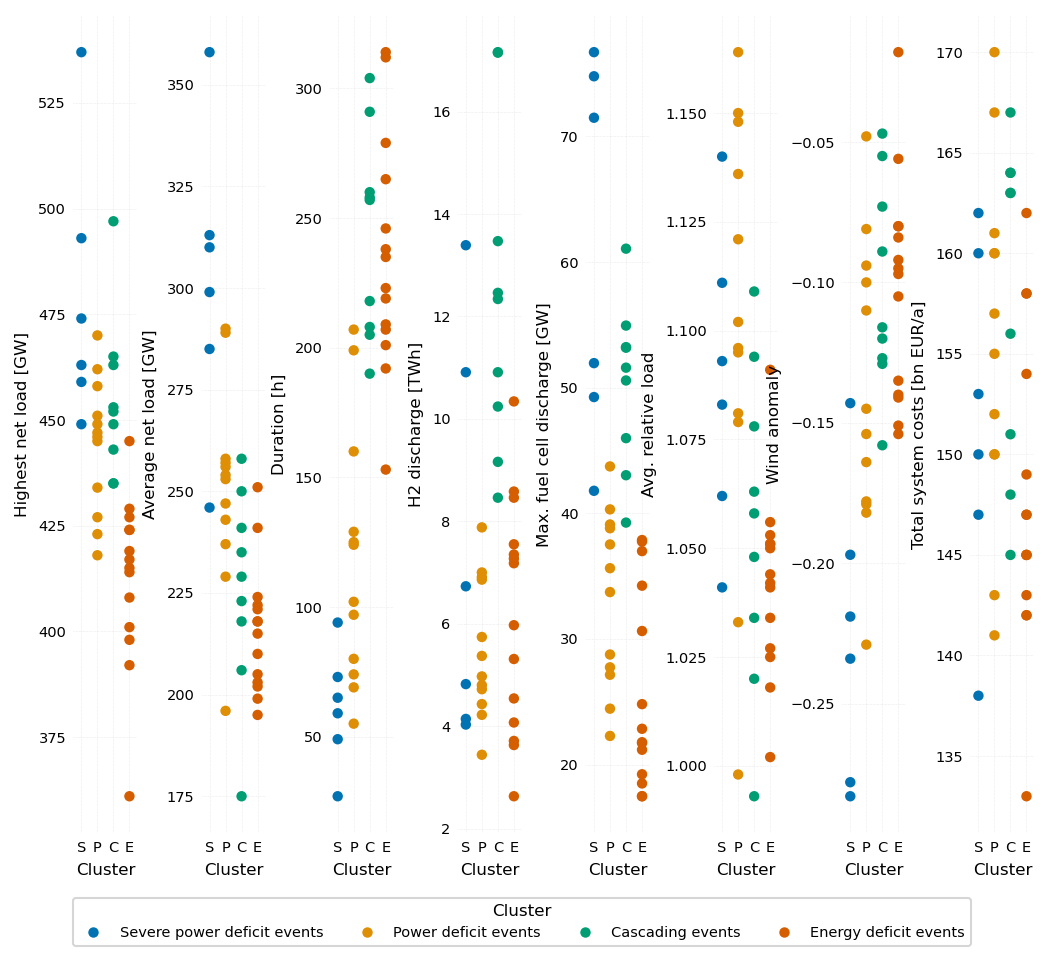

In [30]:
clustered_heatmap = heatmap.copy()
clustered_heatmap["cluster"] = kmeans_vals.labels_

# Order clusters: 0: Cascading events, 1: Energy deficit events, 2: Severe power deficit events, 3: Power deficit events.
clustered_heatmap["cluster"] = clustered_heatmap["cluster"].replace({0: "C", 1: "E", 2: "S", 3: "P"})

# Create new palette from the following colours: "#2A1828", "#4F5D87", "#83A5BA", "#2F3C30"

# Plot stripplot

fig, axs = plt.subplots(1, 8, figsize=(21 * cm, 18 * cm), gridspec_kw={'wspace': 1, 'hspace': 2})

# Reset the index of the heatmap DataFrame
clustered_heatmap_reset = clustered_heatmap.reset_index()

# Sort clustered_heatmap_reset by "S", "P", "C", "E"
clustered_heatmap_reset["cluster"] = pd.Categorical(
    clustered_heatmap_reset["cluster"], 
    categories=["S", "P", "C", "E"],
    ordered=True
)

for (i, col), pretty_name in zip(enumerate(clustered_heatmap.columns[:-1]),["Highest net load [GW]", "Average net load [GW]", "Duration [h]", "H2 discharge [TWh]", "Max. fuel cell discharge [GW]", "Avg. relative load", "Wind anomaly", "Total system costs [bn EUR/a]"]):
    sns.stripplot(
        data=clustered_heatmap_reset,
        y=col,
        x = "cluster",
        hue="cluster",
        ax=axs[i],
        jitter=0,
        alpha=1,
        size=5,
        palette="colorblind",
        legend=True,
    )
    axs[i].set_ylabel(pretty_name, fontsize=8)
    axs[i].set_xlabel("Cluster", fontsize=8)
    axs[i].legend().set_visible(False)
    sns.despine(ax=axs[i], left=True, bottom=True)
    axs[i].tick_params(axis="both", which="both", length=0, labelsize=7)
    # Set grid.
    axs[i].grid(True, linestyle=':', linewidth=0.25, alpha=0.5)
    

# Add manual legend below plots.
handles, labels = axs[3].get_legend_handles_labels()
axs[3].legend(handles=handles, labels=["Severe power deficit events", "Power deficit events", "Cascading events", "Energy deficit events"], loc='upper center', bbox_to_anchor=(1, -0.07), ncol=5, title = "Cluster", fontsize=7, title_fontsize=8)
plt.savefig("paper_plots/supp_mat/kpis_clustered.pdf", bbox_inches="tight")


## S14: Cluster centroids

In [31]:
# Print the cluster centroids
cluster_centroids = pd.DataFrame(kmeans_vals.cluster_centers_ * clustered_vals.std()[:-1].values + clustered_vals.mean()[:-1].values, columns=clustered_vals.columns[:-1])
cluster_centroids.T

0           1           2           3
highest_net_load  454.666667  412.428571  479.166667  444.166667
avg_net_load      226.111111  216.000000  301.833333  250.750000
duration          243.444444  235.214286   61.166667  118.416667
h2_discharge       12.372222    6.185000    7.336667    5.528333
max_fc_discharge   50.314444   25.893571   60.991667   33.268333
avg_rel_load        1.055222    1.041786    1.088333    1.100250
wind_anom          -0.101556   -0.102000   -0.225667   -0.138667

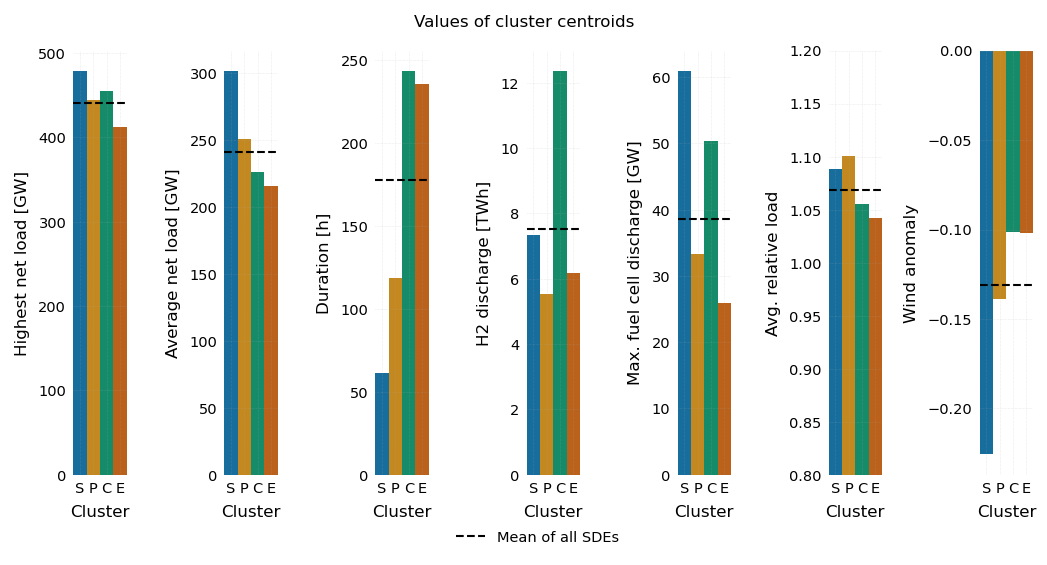

In [32]:
df_centroids = cluster_centroids.copy()
df_centroids.index = ["C", "E", "S", "P"]

# Sort df_centroids by order of clusters according to S, P, C, E
df_centroids = df_centroids.loc[["S", "P", "C", "E"]]

# Can you create a bar chart similar to the stripplot with seaborn as before?
fig, axs = plt.subplots(1, 7, figsize=(18 * cm, 10 * cm))
fig.suptitle("Values of cluster centroids", fontsize=8, y=0.95)
for i, (col, pretty_name) in enumerate(zip(df_centroids.columns, ["Highest net load [GW]", "Average net load [GW]", "Duration [h]", "H2 discharge [TWh]", "Max. fuel cell discharge [GW]", "Avg. relative load", "Wind anomaly"])):
    sns.barplot(
        data=df_centroids.reset_index(),
        x="index",
        y=col,
        ax=axs[i],
        width=1,
        palette="colorblind",
        ci=None,
    )

    # Plot mean values with dashed line (clustered_vals[['highest_net_load', 'avg_net_load', 'duration', 'h2_discharge', 'max_fc_discharge', 'avg_rel_load', 'wind_anom']])
    axs[i].axhline(clustered_vals[col].mean(), color='black', linestyle='--', linewidth=1, label="Mean")
    axs[i].set_ylabel(pretty_name, fontsize=8)
    axs[i].set_xlabel("Cluster", fontsize=8)
    axs[i].legend().set_visible(False)
    sns.despine(ax=axs[i], left=True, bottom=True)
    axs[i].tick_params(axis="both", which="both", length=0, labelsize=7)
    # Set grid.
    axs[i].grid(True, linestyle=':', linewidth=0.25, alpha=0.5)
    if pretty_name == "Avg. relative load":
        axs[i].set_ylim(0.8, 1.2)
# Add manual legend with mean below.
handles, labels = axs[3].get_legend_handles_labels()
axs[3].legend(handles=handles, labels=["Mean of all SDEs"], loc='upper center', bbox_to_anchor=(0.2, -0.1), ncol=1, frameon=False, fontsize=7, title_fontsize=8)
plt.tight_layout()
plt.savefig("paper_plots/supp_mat/cluster-centroids.pdf", bbox_inches="tight")


## S16-19: All four clusters

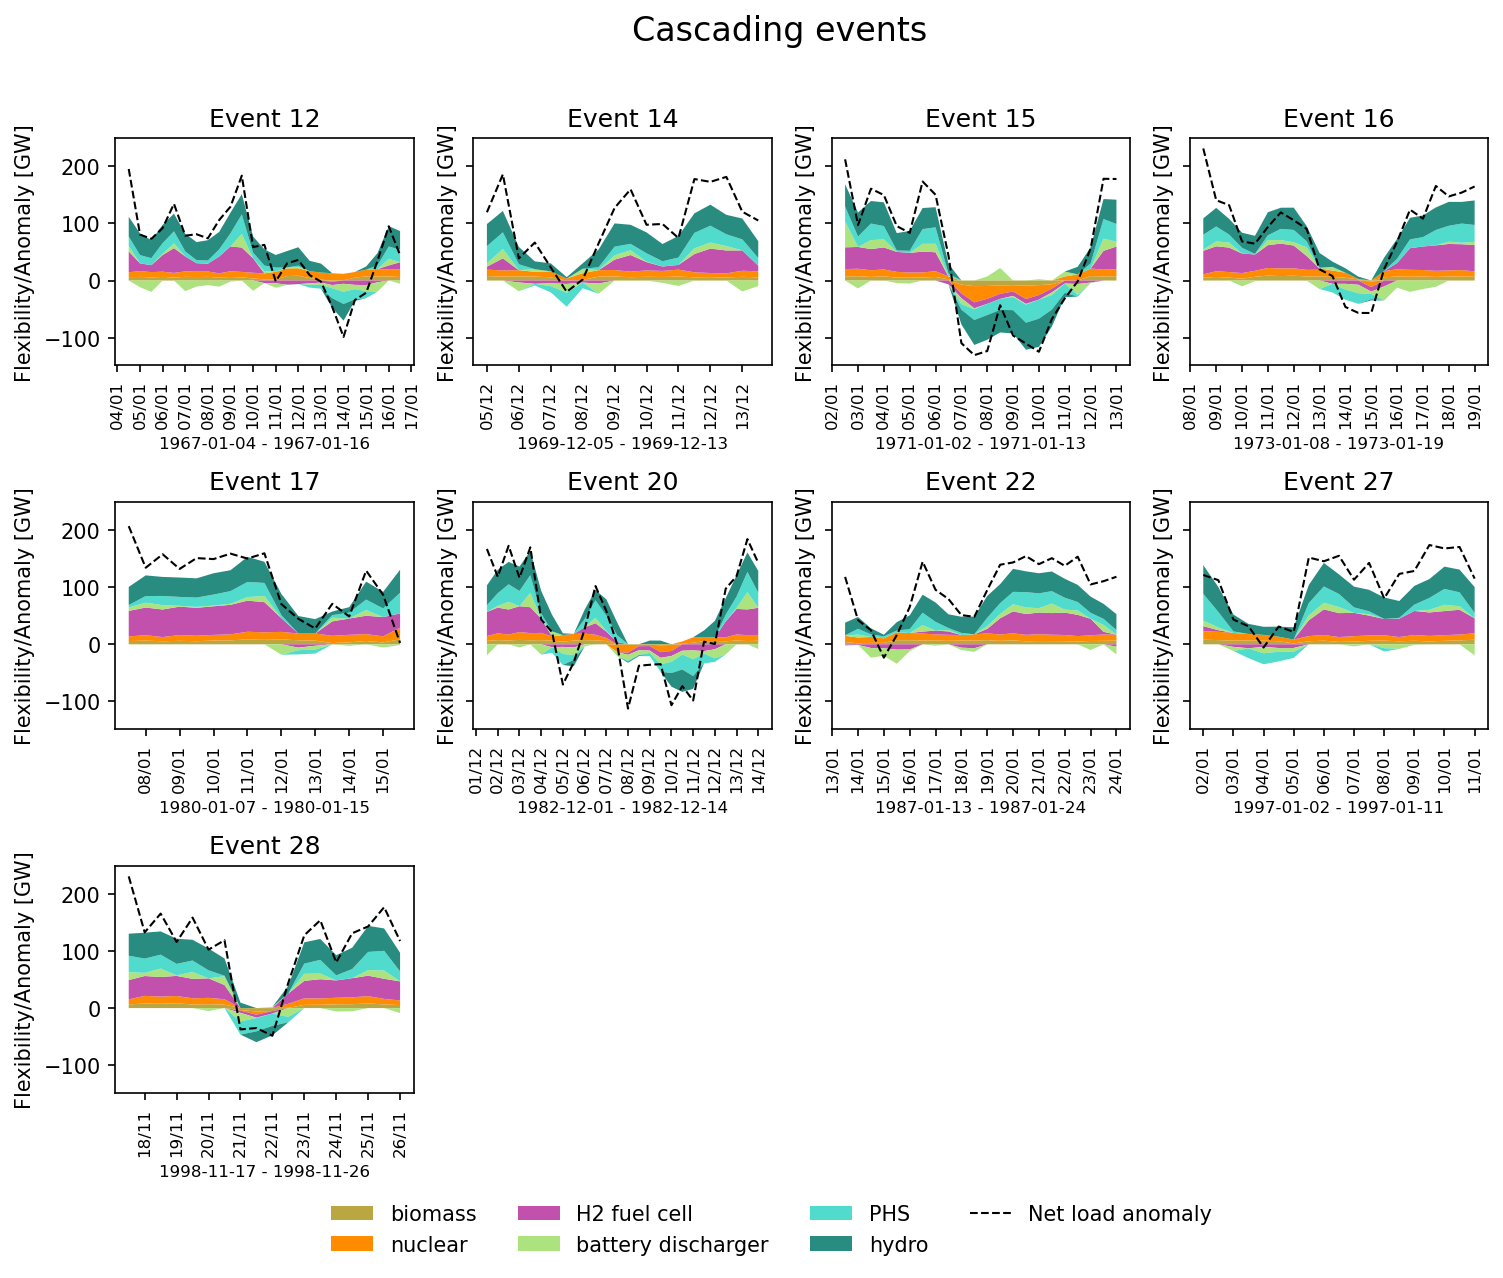

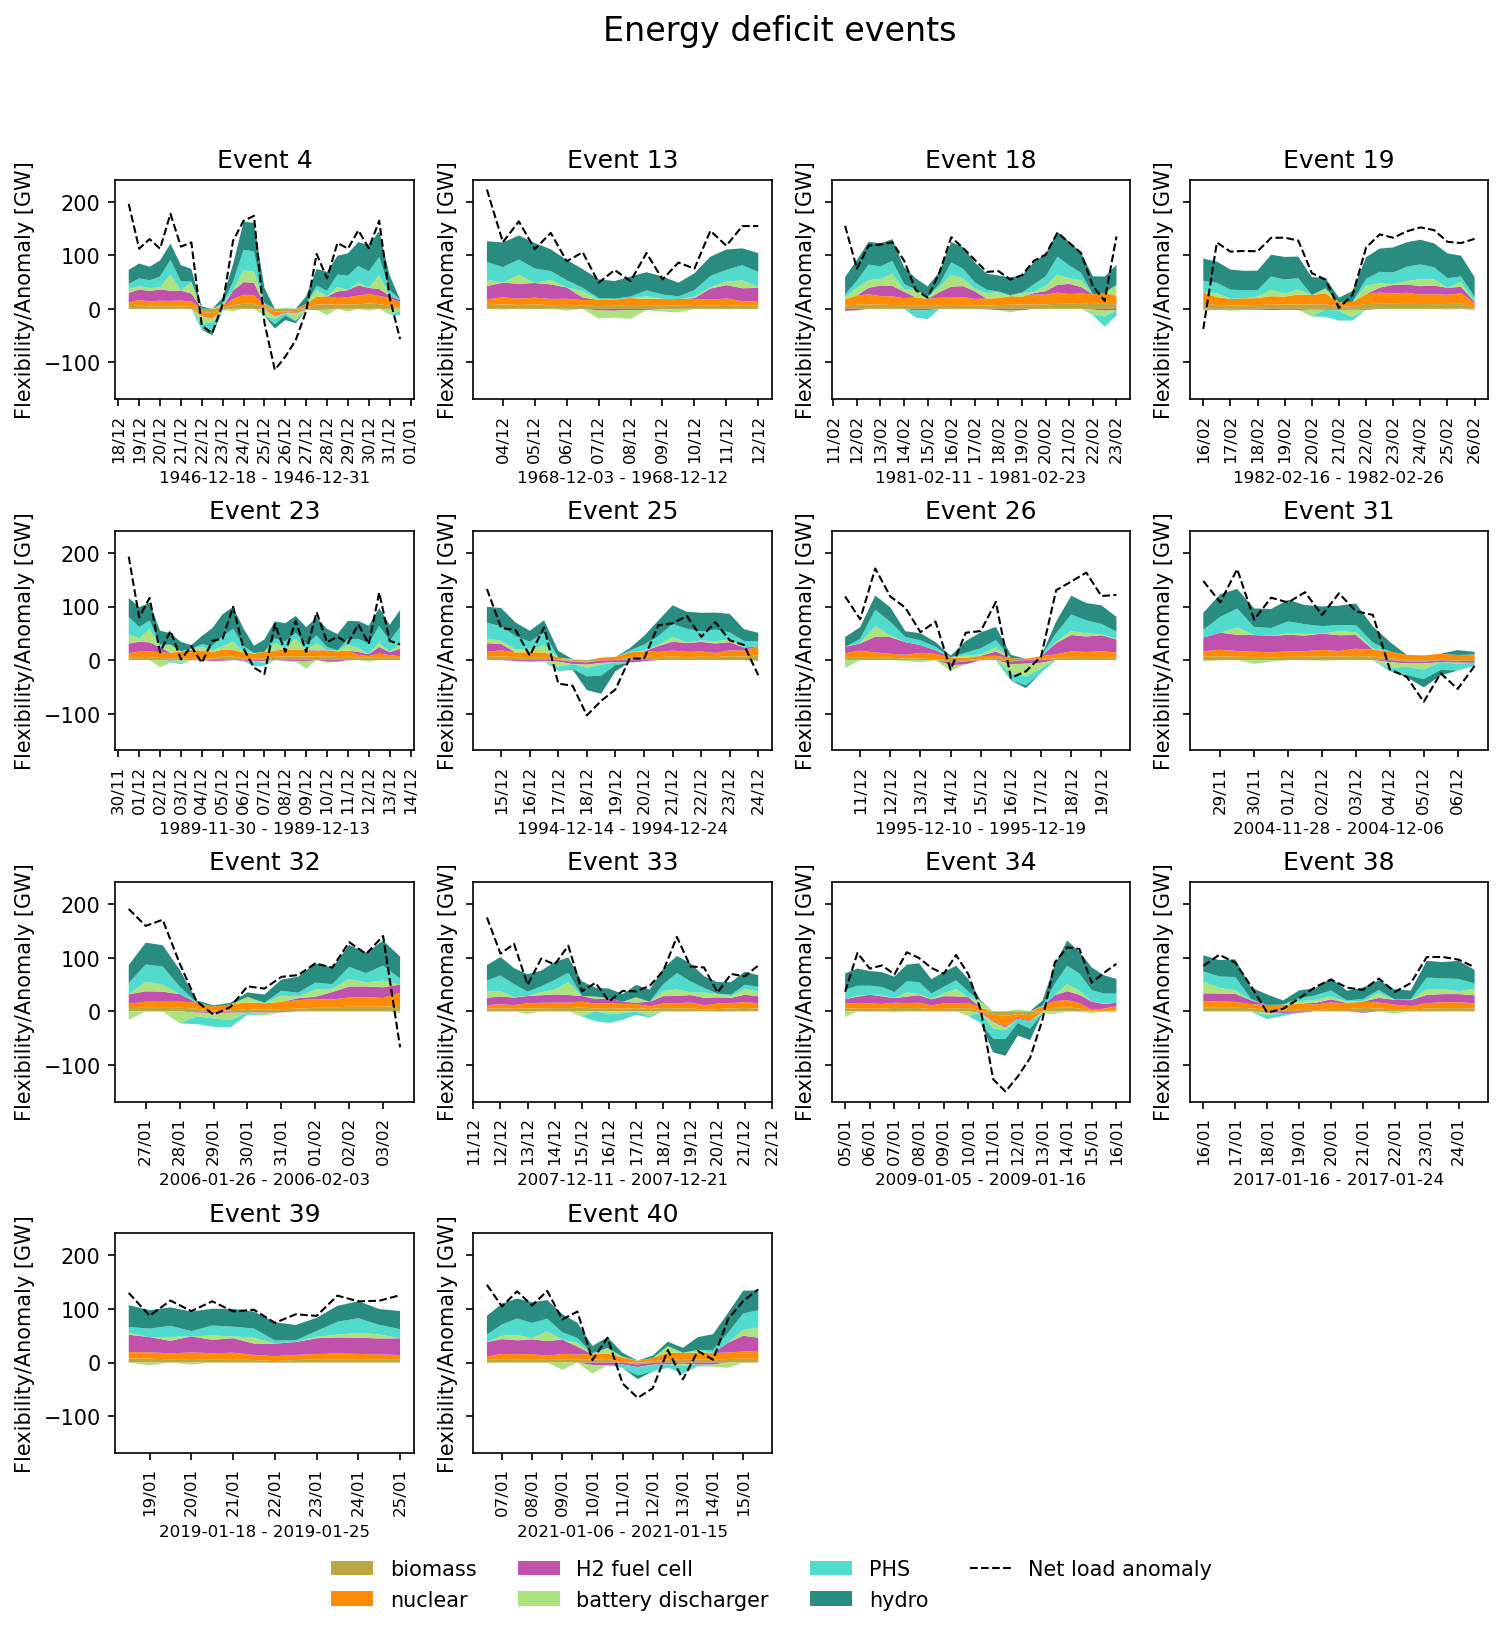

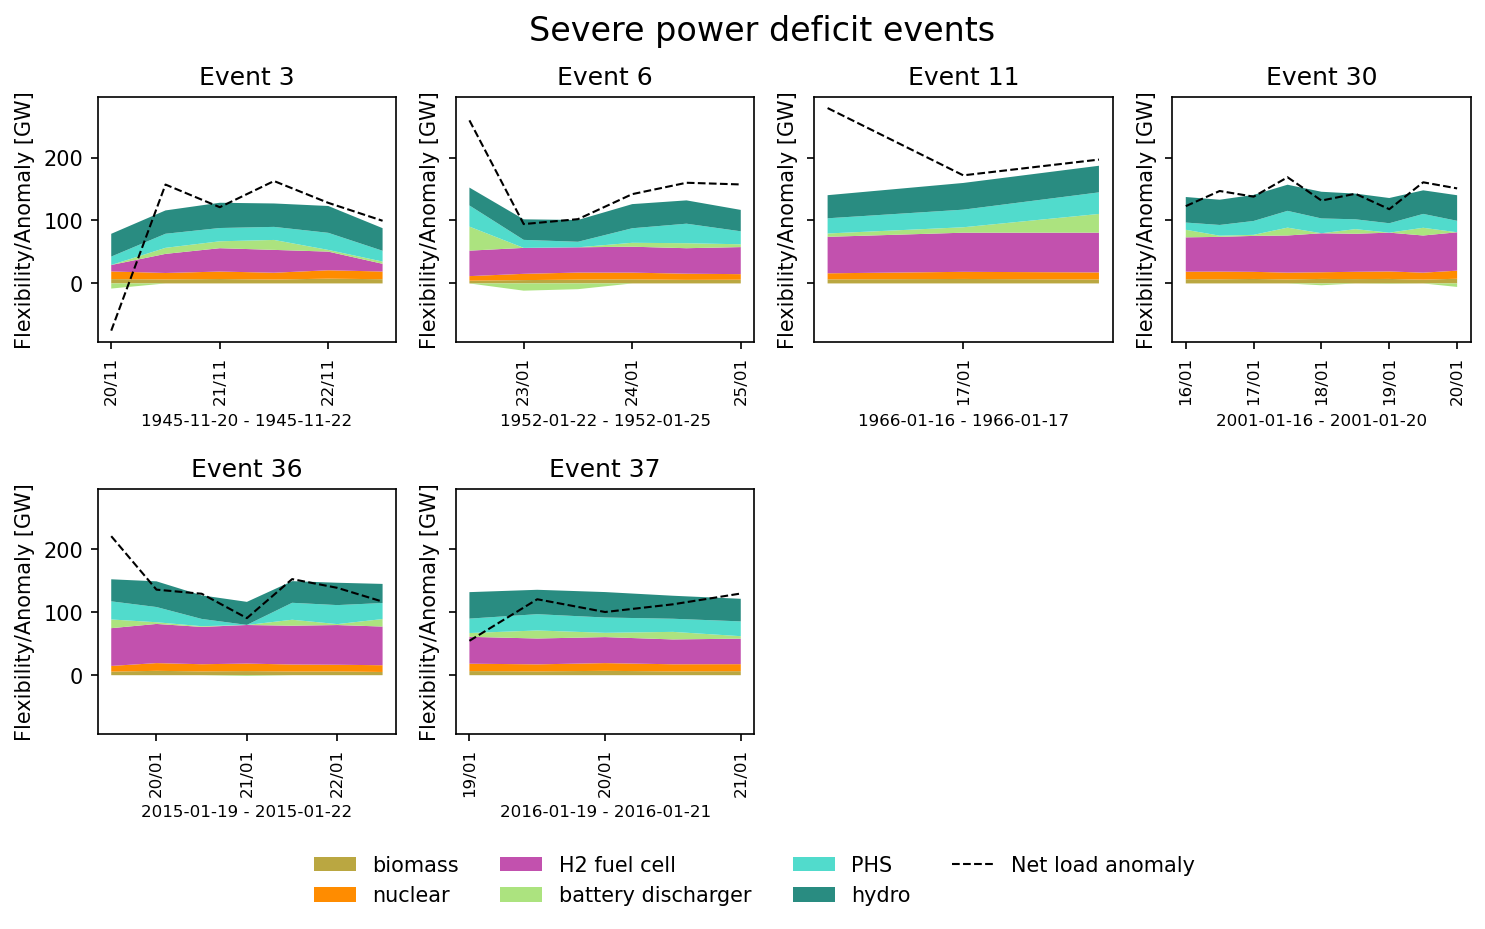

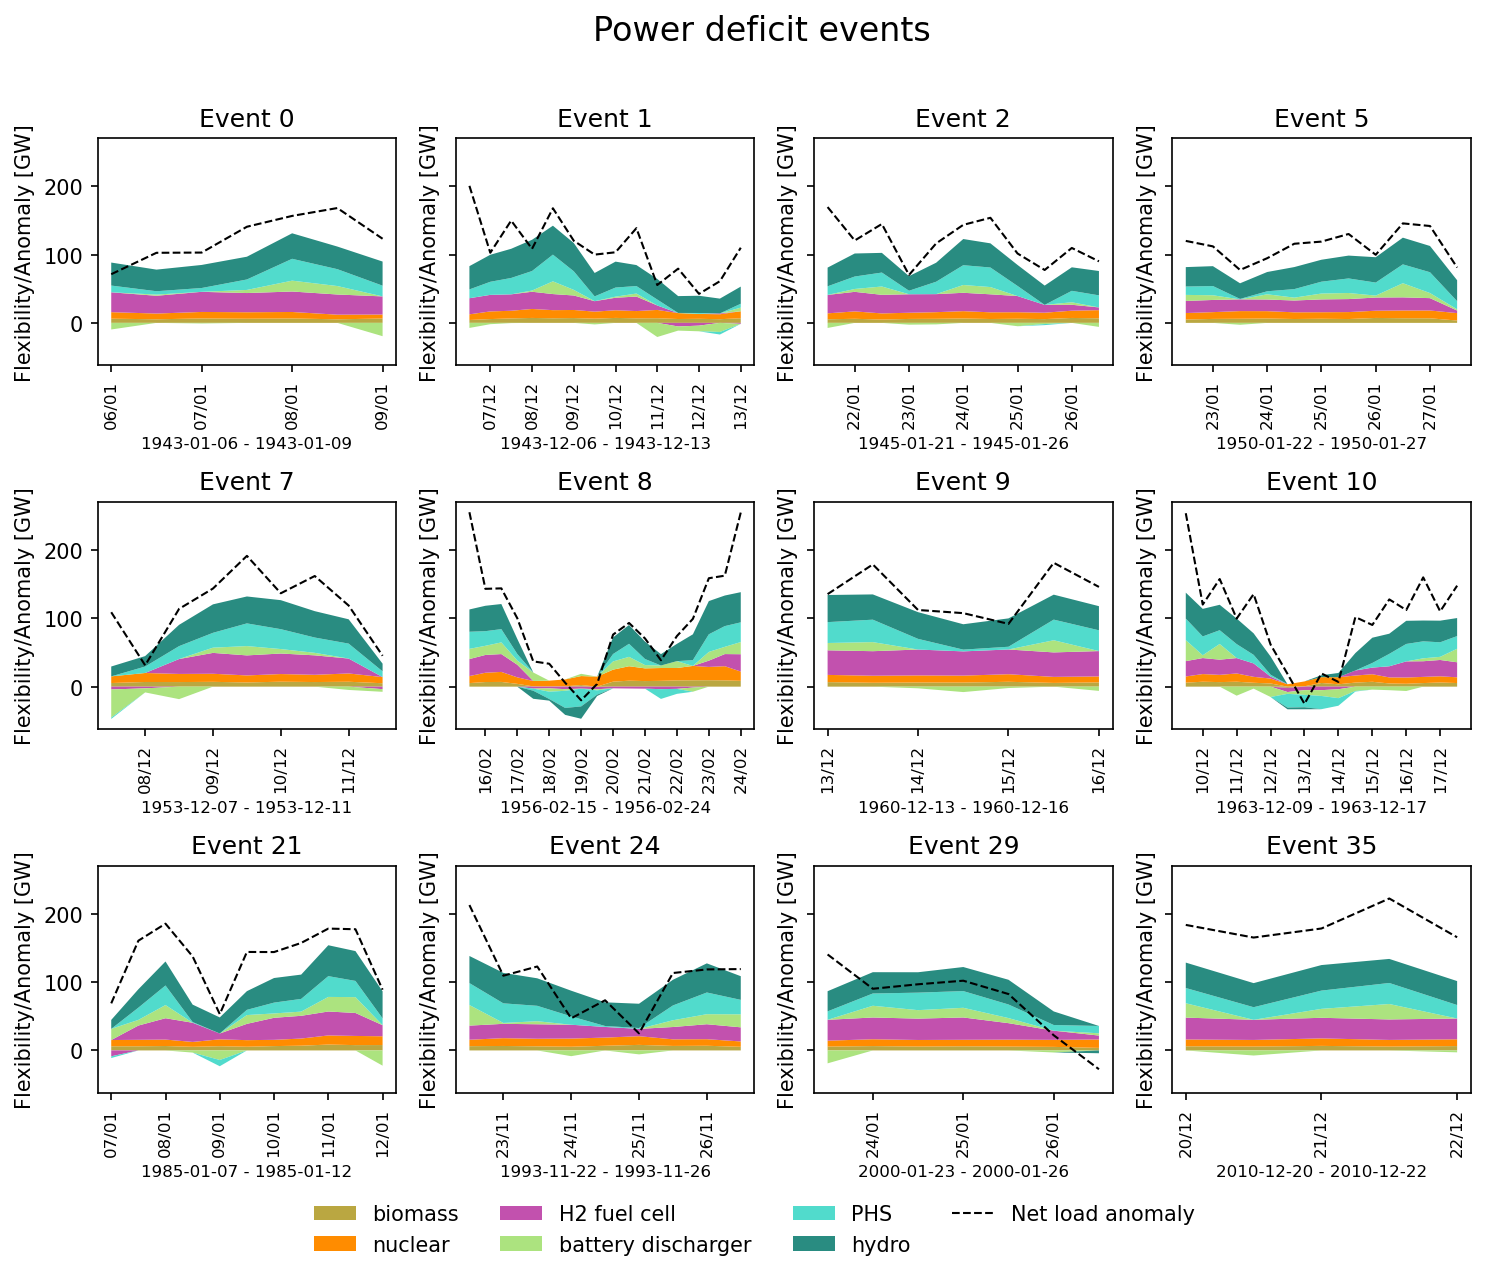

In [33]:
plot_cluster_anomalies(all_flex_anomaly, all_system_anomaly, periods, 4, clustered_vals,  plot_all_system=False, resampled="12h", save_fig=True, path_str = "./paper_plots/supp_mat/", cluster_names=["Cascading events", "Energy deficit events", "Severe power deficit events", "Power deficit events"])

# Annual values

## S15: Net load across years

In [34]:
# Annual stats: longest deficit, highest net load, highest weekly load
longest_deficit = pd.read_csv(f"{folder}/longest_net_load_deficit.csv", index_col=0)
highest_deficit = pd.read_csv(f"{folder}/highest_net_load_deficit.csv", index_col=0)
max_weekly_net_load = pd.read_csv(f"{folder}/max_weekly_net_load.csv", index_col=0)

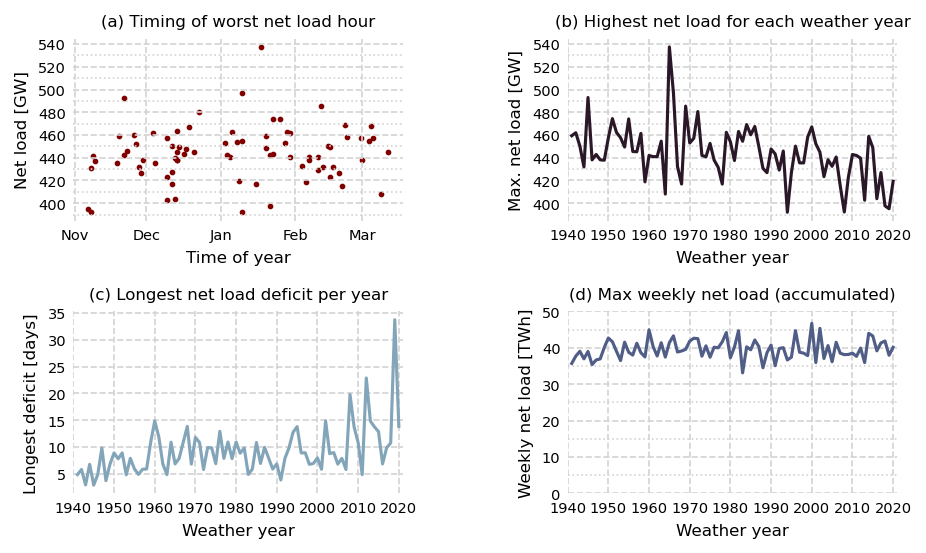

In [35]:
# Create a plot with timing of net load as well as stats of net load throughout the years.

fig, axs = plt.subplots(2, 2, figsize = (18*cm, 10*cm), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.5, 'hspace': 0.5})

# Timing of worst net load hour.
ax = axs[0,0]
ax.set_title("(a) Timing of worst net load hour", fontsize=8)
temp_df = highest_deficit.copy()
# Set temp_df.time to be timestamps.
temp_df["time"] = pd.to_datetime(temp_df["time"])
# Replace the first four strings by the same year, 1941, in "time".
temp_df["time"] = temp_df["time"].apply(lambda x: x.replace(year=1942, month=x.month, day=x.day) if x.month < 7 else x.replace(year=1941, month=x.month, day=x.day))


ax.scatter(temp_df["time"], temp_df["value"]/1e3, color="maroon", marker="o", s=3, label="Highest residual load")
ax.set_xlabel("Time of year", fontsize=8)
ax.set_ylabel("Net load [GW]", fontsize=8)
ax.tick_params(axis='both', which="both", length=0, labelsize=7)

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='lightgray', linestyle='--', which='major')
ax.xaxis.grid(color='lightgray', linestyle='--', which='major')

# Highest net load for each weather year.
ax = axs[0,1]
ax.set_title("(b) Highest net load for each weather year", fontsize=8)
(highest_deficit["value"]/1e3).plot(ax=ax, color=colours_midnights[0], label="Highest residual load")
ax.set_ylabel("Max. net load [GW]", fontsize=8)
ax.set_xlabel("Weather year", fontsize=8)
ax.tick_params(axis='both', which="major", length=0, labelsize=7)
ax.tick_params(axis='y', which="minor", length=0, labelsize=7)
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='lightgray', linestyle='--', which='major')
ax.xaxis.grid(color='lightgray', linestyle='--', which='major')
ax.set_xlim(1940,2021)

# Longest deficit per year
ax = axs[1,0]
ax.set_title("(c) Longest net load deficit per year", fontsize=8)
(longest_deficit["hours"]/24).plot(ax=ax, color = colours_midnights[2])
ax.set_ylabel("Longest deficit [days]", fontsize=8)
ax.set_xlabel("Weather year", fontsize=8)
ax.tick_params(axis='y', which = "both", length=0, labelsize=7)
ax.tick_params(axis='x', which = "major", length=0, labelsize=7)
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='lightgray', linestyle='--', which='major')
ax.xaxis.grid(color='lightgray', linestyle='--', which='major')
ax.set_xlim(1940,2021)

# Max weekly net load (accumulated)
ax = axs[1,1]
ax.set_title("(d) Max weekly net load (accumulated)", fontsize=8)
(max_weekly_net_load["total"]/1e6).plot(ax=ax, color = colours_midnights[1])
ax.set_ylabel("Weekly net load [TWh]", fontsize=8)
ax.set_xlabel("Weather year", fontsize=8)
ax.tick_params(axis='y', which = "both", length=0, labelsize=7)
ax.tick_params(axis='x', which = "major", length=0, labelsize=7)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='lightgray', linestyle='--', which='major')
ax.yaxis.grid(color='lightgray', linestyle=':', which='minor')
ax.xaxis.grid(color='lightgray', linestyle='--', which='major')
ax.set_xlim(1940,2021)
ax.set_ylim(0,50)

fig.savefig("paper_plots/supp_mat/net-load_trends.pdf", bbox_inches="tight")



## S30: Winter load

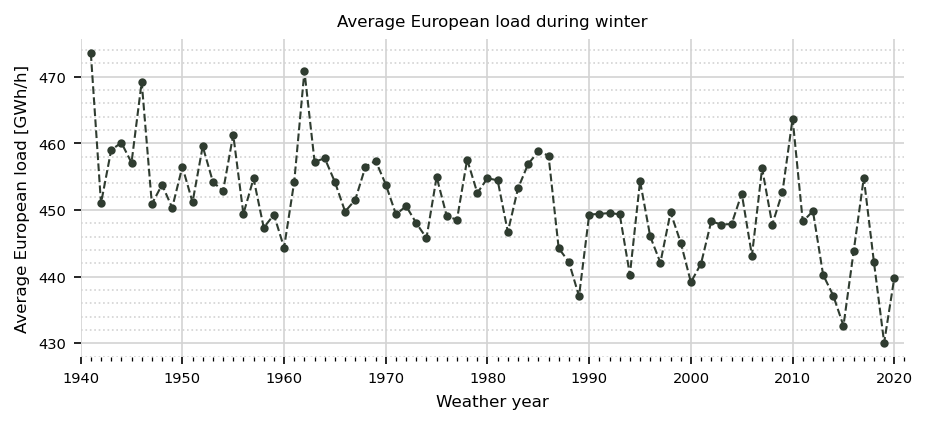

In [36]:
# Winter load

# Plot the avg European load for the different years.
ig, ax = plt.subplots(1,1, figsize=(18*cm, 7*cm))
winter_load.plot(ax=ax, color="#2F3C30", marker="o",markersize=3, linestyle="--", linewidth=1.0, legend=False)

# Labels
ax.set_xlabel("Weather year",fontsize=8)
ax.set_ylabel("Average European load [GWh/h]", fontsize=8)
ax.set_title("Average European load during winter", fontsize=8)

# Ticks, grid
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='y', which='minor', length=0, labelsize=7,rotation=90)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.grid(color='lightgray', linestyle='solid', which='major')

ax.set_xlim(1940,2021)

plt.savefig("paper_plots/supp_mat/winter_load.pdf", bbox_inches="tight")

## S31: Renewable CFs

CF for 1936-1946: Offshore 0.481, Onshore 0.273, Wind 0.334
CF for 1947-1957: Offshore 0.473, Onshore 0.283, Wind 0.337
CF for 1958-1968: Offshore 0.472, Onshore 0.267, Wind 0.332
CF for 1969-1979: Offshore 0.491, Onshore 0.283, Wind 0.345
CF for 1980-1990: Offshore 0.490, Onshore 0.296, Wind 0.356
CF for 1991-2001: Offshore 0.490, Onshore 0.286, Wind 0.347
CF for 2002-2012: Offshore 0.488, Onshore 0.270, Wind 0.336
CF for 2013-2023: Offshore 0.501, Onshore 0.290, Wind 0.352


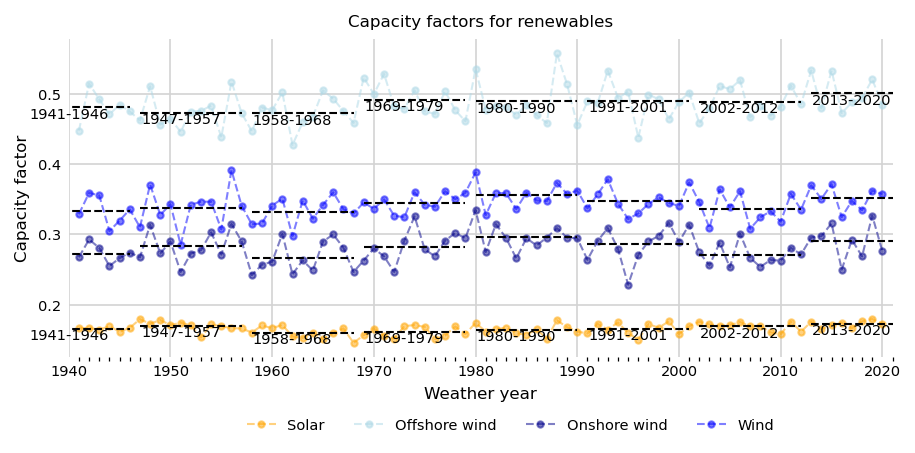

In [37]:
# Renewable capacity factors throughout the years

# Compute capacity factor (Europe-wide) for solar, wind power, onshore wind power and offshore wind power.

fig, ax = plt.subplots(1,1, figsize=(18*cm, 7*cm))
annual_cfs[["wind", "onwind", "offwind", "solar"]].plot(ax=ax, color=["blue", "darkblue", "lightblue","orange"], marker="o", markersize=3, linestyle="--", linewidth=1.0, alpha=0.5)
# Add line for every decade.
step = 11
for i in range(1936, 2020, step):
    ax.hlines(annual_cfs.loc[i:i+step-1,"wind"].mean(), i, i+step-1, color="black", lw=1, linestyle="--")
    ax.hlines(annual_cfs.loc[i:i+step-1,"onwind"].mean(), i, i+step-1, color="black", lw=1, linestyle="--")
    ax.hlines(annual_cfs.loc[i:i+step-1,"offwind"].mean(), i, i+step-1, color="black", lw=1, linestyle="--")
    ax.hlines(annual_cfs.loc[i:i+step-1,"solar"].mean(), i, i+step-1, color="black", lw=1, linestyle="--")
    # Add annotation for the decade in the middle
    ax.text(i+4, annual_cfs.loc[i:i+step-1, "offwind"].mean(), f"{max(1941,i)}-{min(i+step-1,2020)}", verticalalignment="top", horizontalalignment="center", fontsize=7)
    print(f"CF for {i}-{i+step-1}: Offshore {annual_cfs.loc[i:i+step-1, 'offwind'].mean():.3f}, Onshore {annual_cfs.loc[i:i+step-1, 'onwind'].mean():.3f}, Wind {annual_cfs.loc[i:i+step-1, 'wind'].mean():.3f}")
    ax.text(i+4, annual_cfs.loc[i:i+step-1, "solar"].mean(), f"{max(i, 1941)}-{min(i+step-1,2020)}", verticalalignment="top", horizontalalignment="center", fontsize=7)
# Labels
# Labels
ax.set_xlabel("Weather year", fontsize=8)
ax.set_ylabel("Capacity factor", fontsize=8)
ax.set_title("Capacity factors for renewables", fontsize=8)

# Ticks, grid
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
sns.despine(ax=ax, left=True, bottom=True)
ax.tick_params(axis='both', which='major', length=0, labelsize=7)
ax.tick_params(axis='y', which='minor', length=0, labelsize=7,rotation=90)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.grid(color='lightgray', linestyle='solid', which='major')

ax.set_xlim(1940,2021)


# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), ["Solar", "Offshore wind", "Onshore wind", "Wind"], bbox_to_anchor=(0.2, -0.15), loc='upper left', ncol=4, fontsize=7, frameon=False)

plt.savefig("paper_plots/supp_mat/annual_decadal_cfs.pdf", bbox_inches="tight")

## S32: Wasserstein distance for daily net load

In [38]:
net_load_distr = {}
for y in years:
    df = net_load.loc[f"{y}-07-01":f"{y+1}-06-30", "Net load"].resample("1D").mean()
    net_load_distr[y] = df.loc[df.index.month.isin([10, 11, 12, 1, 2, 3])]



# Compute the KDE for each year.
net_load_kdes = {y: gaussian_kde(net_load_distr[y].dropna(), bw_method=0.1) for y in years}

# Compute the Wasserstein distance between each pair of years.
net_load_wasserstein = pd.DataFrame(index=years, columns=years)
for y1 in years:
    for y2 in years:
        net_load_wasserstein.loc[y1, y2] = wasserstein_distance(net_load_distr[y1].dropna(), net_load_distr[y2].dropna())

# Find the five years with the smallest (non zero) Wasserstein distance.
net_load_wasserstein.replace(0, np.nan).stack().nsmallest(5)

1959  1973    2952.494048
1973  1959    2952.494048
2009  2020    3566.122940
2020  2009    3566.122940
2009  2017    3690.839515
dtype: float64

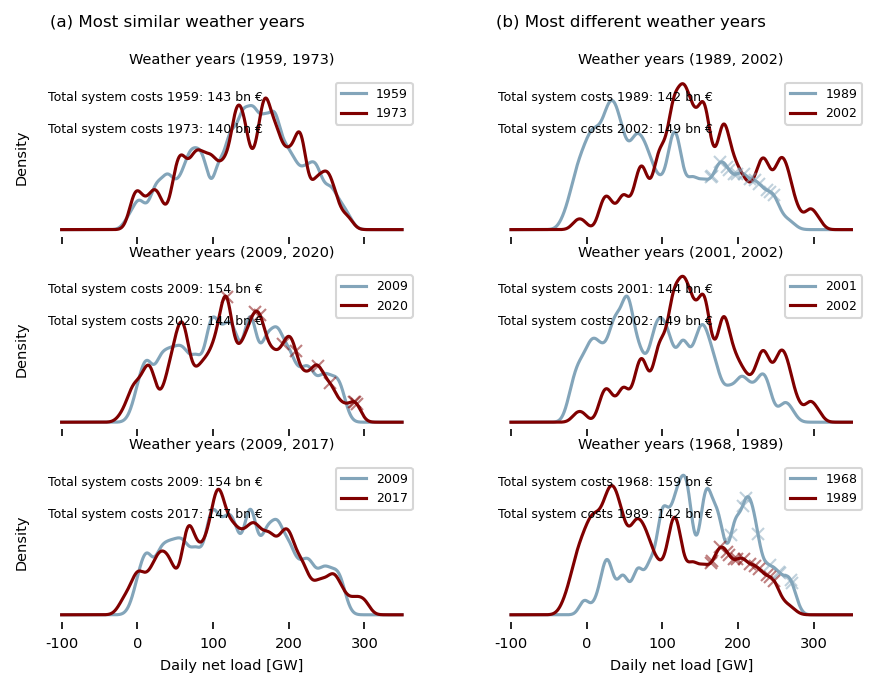

In [39]:
def numfmt(x, pos):
    s = f'{x/1000:,.0f}' #<----
    return s
xfmt = tkr.FuncFormatter(numfmt)

fig, ax = plt.subplots(3,2, figsize=(18.0*cm, 12*cm), sharex=True, sharey=True)

for i, y in enumerate(net_load_wasserstein.replace(0, np.nan).stack().nsmallest(6).index[::2]):
    x = np.linspace(-100000, 350000, 4500)
    ax[i,0].plot(x, net_load_kdes[y[0]](x), label=f"{y[0]}", color=colours_midnights[2])
    ax[i,0].plot(x, net_load_kdes[y[1]](x), label=f"{y[1]}", color="maroon")
    ax[i,0].set_title(f"Weather years {y}", fontsize=7)

    # If there are system-defining events, plot the days of the SDEs.
    year1, year2 = y
    for j, row in periods.iterrows():
        if get_year_period(row) == year1:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = net_load_distr[year1].loc[list_days]
                ax[i,0].plot(list_cfs.values, [net_load_kdes[y[0]](val) for val in list_cfs.values], color=colours_midnights[2], marker = "x", alpha=0.5)
        elif get_year_period(row) == year2:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = net_load_distr[year2].loc[list_days]
                ax[i,0].plot(list_cfs.values, [net_load_kdes[y[1]](val) for val in list_cfs.values], color="maroon",marker = "x",  alpha=0.5)
        else:
            continue

    # Print total system costs for the year in top left corner.
    ax[i,0].text(0.01, 0.85, f"Total system costs {year1}: {reindex_opt_objs.loc[year1]/1e9:.0f} bn €", transform=ax[i,0].transAxes, fontsize=6)
    ax[i,0].text(0.01, 0.65, f"Total system costs {year2}: {reindex_opt_objs.loc[year2]/1e9:.0f} bn €", transform=ax[i,0].transAxes, fontsize=6)

    ax[i,0].set_ylabel("Density", fontsize=7)
    ax[i,0].legend(loc="upper right", fontsize=6)
    ax[-1,0].set_xlabel("Daily net load [GW]", fontsize=7)

for i, y in enumerate(net_load_wasserstein.replace(0, np.nan).stack().nlargest(6).index[::2]):
    x = np.linspace(-100000, 350000, 4500)
    ax[i,1].plot(x, net_load_kdes[y[0]](x), label=f"{y[0]}", color=colours_midnights[2])
    ax[i,1].plot(x, net_load_kdes[y[1]](x), label=f"{y[1]}", color="maroon")
    ax[i,1].set_title(f"Weather years {y}", fontsize=7)

    # If there are system-defining events, plot the days of the SDEs.
    year1, year2 = y
    for j, row in periods.iterrows():
        if get_year_period(row) == year1:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = net_load_distr[year1].loc[list_days]
                ax[i,1].plot(list_cfs.values, [net_load_kdes[y[0]](val) for val in list_cfs.values], color=colours_midnights[2], marker = "x", alpha=0.5)
        elif get_year_period(row) == year2:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = net_load_distr[year2].loc[list_days]
                ax[i,1].plot(list_cfs.values, [net_load_kdes[y[1]](val) for val in list_cfs.values], color="maroon",marker = "x",  alpha=0.5)
        else:
            continue

    # Print total system costs for the year in top left corner.
    ax[i,1].text(0.01, 0.85, f"Total system costs {year1}: {reindex_opt_objs.loc[year1]/1e9:.0f} bn €", transform=ax[i,1].transAxes, fontsize=6)
    ax[i,1].text(0.01, 0.65, f"Total system costs {year2}: {reindex_opt_objs.loc[year2]/1e9:.0f} bn €", transform=ax[i,1].transAxes, fontsize=6)
    ax[i,1].legend(loc="upper right", fontsize=6)
    ax[-1,1].set_xlabel("Daily net load [GW]", fontsize=7)

for axis in ax.flatten():
    axis.tick_params(axis="y", which="both",length=0, labelsize=7)
    axis.tick_params(axis="x", which="both",labelsize=7)
    axis.yaxis.set_ticklabels([])
    # For x-axis set the ticks to be every 100000 and label them as 100's so divide by 1e3 in formatting
    axis.xaxis.set_major_locator(MultipleLocator(100000))
    axis.xaxis.set_major_formatter(xfmt)
    sns.despine(ax=axis, left=True, bottom=True)

fig.text(0.13, 0.95, "(a) Most similar weather years", fontsize=8)
fig.text(0.55, 0.95, "(b) Most different weather years", fontsize=8)

fig.savefig("paper_plots/supp_mat/wasserstein_net-load.pdf", bbox_inches="tight")

plt.show()
plt.close();

## S33: Wasserstein distance for wind CFs

In [40]:
wind_distr = {y: wind_distr_df.loc[y]["0"].dropna() for y in years}
for df in wind_distr.values():
    df.index = pd.to_datetime(df.index)

# Compute the KDE for each year.
kdes = {y: gaussian_kde(wind_distr[y].dropna(), bw_method=0.1) for y in years}

# Compute the Wasserstein distance between each pair of years.
wasserstein = pd.DataFrame(index=years, columns=years)
for y1 in years:
    for y2 in years:
        wasserstein.loc[y1, y2] = wasserstein_distance(wind_distr[y1].dropna(), wind_distr[y2].dropna())

# Find the five years with the smallest (non zero) Wasserstein distance.
wasserstein.replace(0, np.nan).stack().nsmallest(5)

1986  1997    0.005322
1997  1986    0.005322
1968  2016    0.005414
2016  1968    0.005414
1946  1981    0.005476
dtype: float64

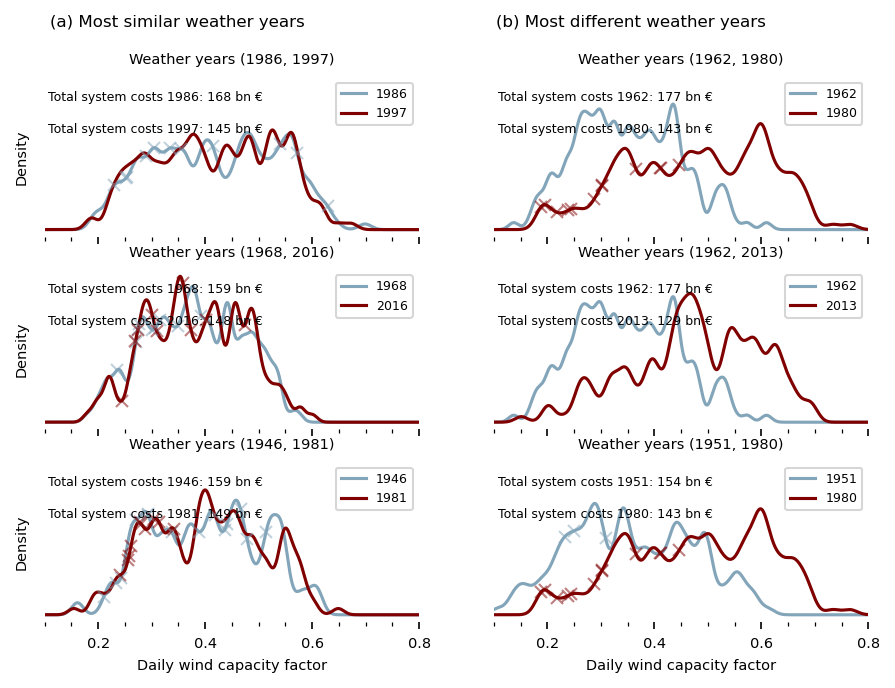

In [41]:
# Regenerate the same plot with two columns only with wind cf this time.
# Plot the distribution of the wind capacity factors for the years with the largest Wasserstein distance.

fig, ax = plt.subplots(3,2, figsize=(18.0*cm, 12*cm), sharex=True, sharey=True)

for i, y in enumerate(wasserstein.replace(0, np.nan).stack().nsmallest(6).index[::2]):
    x = np.linspace(0,1,1000)
    ax[i,0].plot(x, kdes[y[0]](x), label=f"{y[0]}", color=colours_midnights[2])
    ax[i,0].plot(x, kdes[y[1]](x), label=f"{y[1]}", color="maroon")
    ax[i,0].set_title(f"Weather years {y}", fontsize=7)

    # If there are system-defining events, plot the days of the SDEs.
    year1, year2 = y
    for j, row in periods.iterrows():
        if get_year_period(row) == year1:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = wind_distr[year1].loc[list_days]
                ax[i,0].plot(list_cfs.values, [kdes[y[0]](val) for val in list_cfs.values], color=colours_midnights[2], marker = "x", alpha=0.5)
        elif get_year_period(row) == year2:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = wind_distr[year2].loc[list_days]
                ax[i,0].plot(list_cfs.values, [kdes[y[1]](val) for val in list_cfs.values], color="maroon",marker = "x",  alpha=0.5)
        else:
            continue

    # Print total system costs for the year in top left corner.
    ax[i,0].text(0.01, 0.85, f"Total system costs {year1}: {reindex_opt_objs.loc[year1]/1e9:.0f} bn €", transform=ax[i,0].transAxes, fontsize=6)
    ax[i,0].text(0.01, 0.65, f"Total system costs {year2}: {reindex_opt_objs.loc[year2]/1e9:.0f} bn €", transform=ax[i,0].transAxes, fontsize=6)

    ax[i,0].set_ylabel("Density", fontsize=7)
    ax[i,0].legend(loc="upper right", fontsize=6)
    ax[-1,0].set_xlabel("Daily wind capacity factor", fontsize=7)

for i, y in enumerate(wasserstein.replace(0, np.nan).stack().nlargest(6).index[::2]):
    x = np.linspace(0, 1, 1000)
    ax[i,1].plot(x, kdes[y[0]](x), label=f"{y[0]}", color=colours_midnights[2])
    ax[i,1].plot(x, kdes[y[1]](x), label=f"{y[1]}", color="maroon")
    ax[i,1].set_title(f"Weather years {y}", fontsize=7)

    # If there are system-defining events, plot the days of the SDEs.
    year1, year2 = y
    for j, row in periods.iterrows():
        if get_year_period(row) == year1:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = wind_distr[year1].loc[list_days]
                ax[i,1].plot(list_cfs.values, [kdes[y[0]](val) for val in list_cfs.values], color=colours_midnights[2], marker = "x", alpha=0.5)
        elif get_year_period(row) == year2:
            days = periods.loc[periods.index[j]]
            for k in range((days["end"] - days["start"]).days + 1):
                list_days = [(days["start"] + dt.timedelta(days=k)).date()]
                list_cfs = wind_distr[year2].loc[list_days]
                ax[i,1].plot(list_cfs.values, [kdes[y[1]](val) for val in list_cfs.values], color="maroon",marker = "x",  alpha=0.5)
        else:
            continue

    # Print total system costs for the year in top left corner.
    ax[i,1].text(0.01, 0.85, f"Total system costs {year1}: {reindex_opt_objs.loc[year1]/1e9:.0f} bn €", transform=ax[i,1].transAxes, fontsize=6)
    ax[i,1].text(0.01, 0.65, f"Total system costs {year2}: {reindex_opt_objs.loc[year2]/1e9:.0f} bn €", transform=ax[i,1].transAxes, fontsize=6)
    ax[i,1].legend(loc="upper right", fontsize=6)
    ax[-1,1].set_xlabel("Daily wind capacity factor", fontsize=7)

for axis in ax.flatten():
    axis.tick_params(axis="y", which="both",length=0, labelsize=7)
    axis.tick_params(axis="x", which="both",labelsize=7)
    axis.yaxis.set_ticklabels([])
    # For x-axis set the ticks to be every 100000 and label them as 100's so divide by 1e3 in formatting
    axis.xaxis.set_major_locator(MultipleLocator(0.2))
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.xaxis.set_minor_locator(MultipleLocator(0.05))
    axis.set_xlim(0.1,0.8)
    sns.despine(ax=axis, left=True, bottom=True)
    

fig.text(0.13, 0.95, "(a) Most similar weather years", fontsize=8)
fig.text(0.55, 0.95, "(b) Most different weather years", fontsize=8)

fig.savefig("paper_plots/supp_mat/wasserstein_wind.pdf", bbox_inches="tight")

plt.show()
plt.close();






# Resilience metrics

## S22: Correlations of resilience metrics and SDE occurrence

In [42]:
# Need to run _unserved_energy.py to get these data.

share_unserved = pd.read_csv(f"processing_data/{c1_config_name}/share_unserved.csv", index_col=0)
max_unserved = pd.read_csv(f"processing_data/{c1_config_name}/max_unserved.csv", index_col=0)
unserved = pd.read_csv(f"processing_data/{c1_config_name}/unserved.csv", index_col=0)
for df in [share_unserved, max_unserved, unserved]:
    df.index = [str(year) for year in years]
    df.columns = [str(year) for year in years]

# Unserved energy (in percent)
share_unserved_reorder = share_unserved.mean(axis="columns")
op_share_unserved_reorder = share_unserved.mean(axis="index")
share_unserved_reorder.index = system_costs.index
op_share_unserved_reorder.index = system_costs.index

# Max unserved load (in GW)
max_unserved_reorder = max_unserved.mean(axis="columns")
op_max_unserved_reorder = max_unserved.mean(axis="index")
max_unserved_reorder.index = system_costs.index
op_max_unserved_reorder.index = system_costs.index

# Rank years by difficulty of design year and operational year and compare whether these match.
ranked_years_ls = pd.DataFrame(index = years, columns = ["Design year", "Operational year", "SDE"]).astype(float)


sorted_design_years = max_unserved.T.describe().mean().sort_values().rank()
sorted_design_years.index = [int(i) for i in sorted_design_years.index]
sorted_operational_years = max_unserved.describe().mean().sort_values().rank(ascending=False)
sorted_operational_years.index = [int(i) for i in sorted_operational_years.index]
                                                                    
ranked_years_ls["Design year"] = sorted_design_years
ranked_years_ls["Operational year"] = sorted_operational_years
ranked_years_ls["SDE"] = 0
ranked_years_ls["System costs"] = reindex_opt_objs.sort_values().rank(ascending=False)
ranked_years_ls["Winter load"] = winter_load.sort_values("load").rank(ascending=False)
ranked_years_ls["Winter wind"] = winter_cfs.sort_values("wind").rank(ascending=True)["wind"]

for year in years:
    ranked_years_ls.loc[year, "Highest deficit"] = net_load.loc[f"{year}-07-01":f"{year+1}-06-30 23:00", "Net load"].max()
ranked_years_ls["Highest deficit"] = ranked_years_ls["Highest deficit"].sort_values().rank(ascending=False)

for i, period in periods.iterrows():
    net_year = get_net_year(period.start)
    ranked_years_ls.loc[net_year, "SDE"] = 1

ranked_years_ue = pd.DataFrame(index = years, columns = ["Design year", "Operational year"]).astype(float) 

sorted_design_years = share_unserved.T.describe().mean().sort_values().rank()
sorted_operational_years = share_unserved.describe().mean().sort_values().rank(ascending=False)
sorted_design_years.index = [int(i) for i in sorted_design_years.index]
sorted_operational_years.index = [int(i) for i in sorted_operational_years.index]                                                              
ranked_years_ue["Design year"] = sorted_design_years
ranked_years_ue["Operational year"] = sorted_operational_years


classification_years = ranked_years_ls.copy()
classification_years.rename(columns={"Design year": "Prevents peaks", "Operational year": "Causes peaks", "Highest deficit": "Highest net load"}, inplace=True)
classification_years["Causes deficit"] = ranked_years_ue["Operational year"].astype(int)
classification_years["Prevents deficits"] = ranked_years_ue["Design year"].astype(int)
classification_years["Lowest annual solar CF"] = annual_cfs.sort_values("solar").rank(ascending=True)["solar"].astype(int)
classification_years["Lowest annual wind CF"] = annual_cfs.sort_values("wind").rank(ascending=True)["wind"].astype(int)

# Reorder according to the following categories:
# - Annual values: total system costs, solar cf, wind cf
# - Winter / weather: winter load
# - Operational: causes deficit, prevents deficits
# - SDE: SDE, highest net load, prevents peaks, causes peaks

classification_years = classification_years[["System costs", "Lowest annual solar CF", "Lowest annual wind CF", "Winter load", "Causes deficit", "Prevents deficits", "SDE", "Highest net load", "Prevents peaks", "Causes peaks",
]]

# Only keep years that have a value below 6 (except SDE)
filtered_classification_years = classification_years.drop("SDE", axis="columns")
filtered_classification_years = filtered_classification_years[filtered_classification_years < 5].dropna(how="all")
filtered_classification_years["SDE"] = classification_years["SDE"]
filtered_classification_years = filtered_classification_years.T

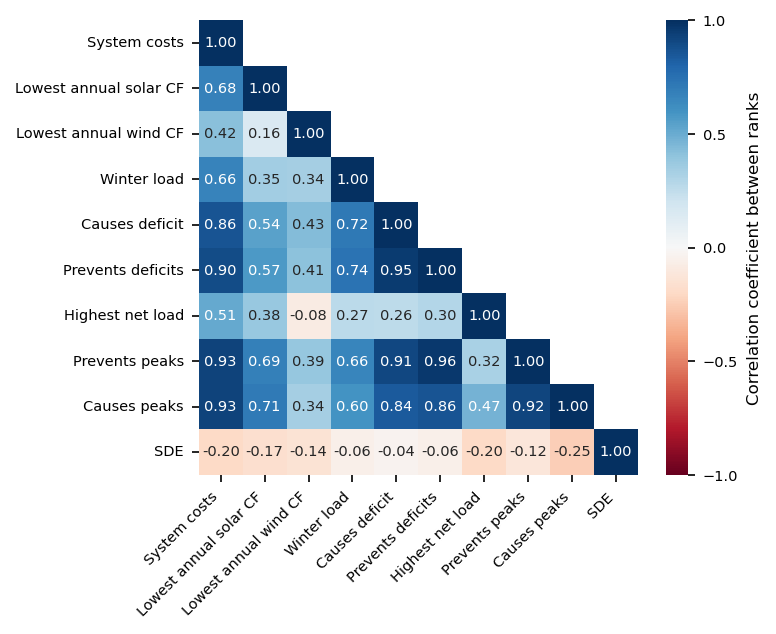

In [43]:
# Plot correlation heatmap with seaborn of classification_years
fig, ax = plt.subplots(figsize=(12 * cm, 10 * cm))

reordered_classification_years = classification_years[["System costs", "Lowest annual solar CF", "Lowest annual wind CF", "Winter load", "Causes deficit", "Prevents deficits", "Highest net load", "Prevents peaks", "Causes peaks", "SDE"]]

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(reordered_classification_years.corr(), dtype=bool), k=1)

sns.heatmap(reordered_classification_years.corr(), mask=mask, annot=True, fmt=".2f", cmap="RdBu", ax=ax, vmin=-1, vmax=1,
            annot_kws={"fontsize": 7}, cbar_kws={"label": "Correlation coefficient", "shrink": 1, "ticks": [-1, -0.5, 0, 0.5, 1]})
# Set font size for colorbar ticks
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Correlation coefficient between ranks", fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=7)

fig.savefig("paper_plots/supp_mat/corr_resilience_metrics.pdf", bbox_inches='tight')

## S23: Quadrant of total system costs vs EENS/max. load shedding

/tmp/ipykernel_82199/180741372.py:135: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handles=handles, labels=labels, ncol=4, loc="upper left", fontsize=7, bbox_to_anchor=(0.1, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)


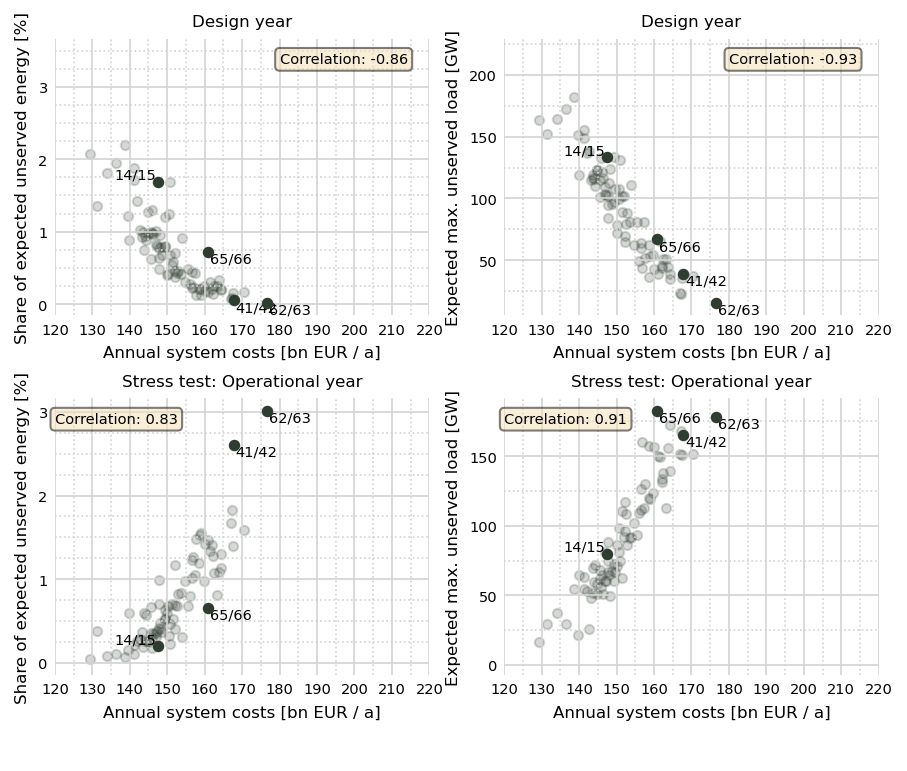

In [44]:
# Basically the same as `plot_scatter_quadrants` from notebook_utilities, but with improved location of text.

# Add plot that compares expected unserved energy to total system costs.
fig, axs = plt.subplots(2, 2, figsize=(18*cm, 14*cm), gridspec_kw={"hspace": 0.3})

# Unserved energy (in percent)
share_unserved_reorder = share_unserved.mean(axis="columns")
op_share_unserved_reorder = share_unserved.mean(axis="index")
share_unserved_reorder.index = system_costs.index
op_share_unserved_reorder.index = system_costs.index

# Max unserved load (in GW)
max_unserved_reorder = max_unserved.mean(axis="columns")
op_max_unserved_reorder = max_unserved.mean(axis="index")
max_unserved_reorder.index = system_costs.index
op_max_unserved_reorder.index = system_costs.index


ax = axs[0,0]
# Scatter plot.
ax.scatter(system_costs, share_unserved_reorder, color="#2F3C30", alpha=0.2, s=20)

# Add correlation.
corr = system_costs.corr(share_unserved_reorder)
ax.text(0.6, 0.95, f"Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Annotate some years such as "62/63", "41/42", "19/20", "14/15", and "65/66"
for i, txt in enumerate(system_costs.index):
    if txt in ["19/20", "14/15"]:
        ax.annotate(txt, (system_costs[i] - 0.5, share_unserved_reorder[i]), fontsize=7, ha='right', va='bottom', color="black")
# Annotate "62/63", "41/42" to the top right
for i, txt in enumerate(system_costs.index):
    if txt in ["62/63", "41/42", "65/66"]:
        ax.annotate(txt, (system_costs[i] + 0.5, share_unserved_reorder[i]), fontsize=7, ha='left', va='top', color="black")
# Scatter plot only those above years with full opacity
ax.scatter(system_costs[["19/20", "14/15", "62/63", "41/42", "65/66"]], share_unserved_reorder[["19/20", "14/15", "62/63", "41/42", "65/66"]], color="#2F3C30", alpha=1, s=20, zorder=3)

#ax.hlines(0.05, color="red", linestyle=":", linewidth=0.5, label="ENTSO-E reliability")

ax.set_ylabel("Share of expected unserved energy [%]", fontsize=8)
ax.set_title("Design year", fontsize=8)

ax = axs[1,0]
# Scatter plot.
ax.scatter(system_costs, op_share_unserved_reorder, color="#2F3C30", alpha=0.2, s=20)

# Add correlation.
corr = system_costs.corr(op_share_unserved_reorder)
ax.text(0, 0.95, f"Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Annotate some years such as "62/63", "41/42", "19/20", "14/15", and "65/66"
for i, txt in enumerate(system_costs.index):
    if txt in ["19/20", "14/15"]:
        ax.annotate(txt, (system_costs[i] - 0.5, op_share_unserved_reorder[i]), fontsize=7, ha='right', va='bottom', color="black")
# Annotate "62/63", "41/42" to the top right
for i, txt in enumerate(system_costs.index):
    if txt in ["62/63", "41/42", "65/66"]:
        ax.annotate(txt, (system_costs[i] + 0.5, op_share_unserved_reorder[i]), fontsize=7, ha='left', va='top', color="black")
# Scatter plot only those above years with full opacity
ax.scatter(system_costs[["19/20", "14/15", "62/63", "41/42", "65/66"]], op_share_unserved_reorder[["19/20", "14/15", "62/63", "41/42", "65/66"]], color="#2F3C30", alpha=1, s=20, zorder=3)


ax.set_ylabel("Share of expected unserved energy [%]", fontsize=8)
ax.set_title("Stress test: Operational year", fontsize=8)

ax = axs[0,1]
# Scatter plot.
ax.scatter(system_costs, max_unserved_reorder, color="#2F3C30", alpha=0.2, s=20)
# Add correlation.
corr = system_costs.corr(max_unserved_reorder)
ax.text(0.6, 0.95, f"Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Annotate some years such as "62/63", "41/42", "19/20", "14/15", and "65/66"
for i, txt in enumerate(system_costs.index):
    if txt in ["19/20", "14/15"]:
        ax.annotate(txt, (system_costs[i] - 0.5, max_unserved_reorder[i]), fontsize=7, ha='right', va='bottom', color="black")
# Annotate "62/63", "41/42" to the top right
for i, txt in enumerate(system_costs.index):
    if txt in ["62/63", "41/42", "65/66"]:
        ax.annotate(txt, (system_costs[i] + 0.5, max_unserved_reorder[i]), fontsize=7, ha='left', va='top', color="black")
# Scatter plot only those above years with full opacity
ax.scatter(system_costs[["19/20", "14/15", "62/63", "41/42", "65/66"]], max_unserved_reorder[["19/20", "14/15", "62/63", "41/42", "65/66"]], color="#2F3C30", alpha=1, s=20, zorder=3)
ax.set_ylabel("Expected max. unserved load [GW]", fontsize=8)
ax.set_title("Design year", fontsize=8)

ax = axs[1,1]
# Scatter plot.
ax.scatter(system_costs, op_max_unserved_reorder, color="#2F3C30", alpha=0.2, s=20)
# Add correlation.
corr = system_costs.corr(op_max_unserved_reorder)
ax.text(0, 0.95, f"Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# Annotate some years such as "62/63", "41/42", "19/20", "14/15", and "65/66"
for i, txt in enumerate(system_costs.index):
    if txt in ["19/20", "14/15"]:
        ax.annotate(txt, (system_costs[i] - 0.5, op_max_unserved_reorder[i]), fontsize=7, ha='right', va='bottom', color="black")
# Annotate "62/63", "41/42" to the top right
for i, txt in enumerate(system_costs.index):
    if txt in ["62/63", "41/42", "65/66"]:
        ax.annotate(txt, (system_costs[i] + 0.5, op_max_unserved_reorder[i]), fontsize=7, ha='left', va='top', color="black")
# Scatter plot only those above years with full opacity
ax.scatter(system_costs[["19/20", "14/15", "62/63", "41/42", "65/66"]], op_max_unserved_reorder[["19/20", "14/15", "62/63", "41/42", "65/66"]], color="#2F3C30", alpha=1, s=20, zorder=3)
ax.set_ylabel("Expected max. unserved load [GW]", fontsize=8)
ax.set_title("Stress test: Operational year", fontsize=8)



for ax in axs[:,0]:
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

for ax in axs[:,1]:
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

for ax in axs.flatten():
    # Labels
    ax.set_xlabel("Annual system costs [bn EUR / a]", fontsize=8)
    

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
    ax.tick_params(axis="x", which="both", length=0, labelsize=7,rotation=0)

    # Ticks, grid

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.grid(color='lightgray', linestyle='solid', which='major')
    ax.xaxis.grid(color='lightgray', linestyle='dotted', which='minor')
    ax.legend(handles=handles, labels=labels, ncol=4, loc="upper left", fontsize=7, bbox_to_anchor=(0.1, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)
    ax.set_xlim(120, 220)


    ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
    ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')


plt.savefig("paper_plots/supp_mat/years_stress_design.pdf", bbox_inches='tight', dpi=300)

## S24: Boxplot of unserved load across years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


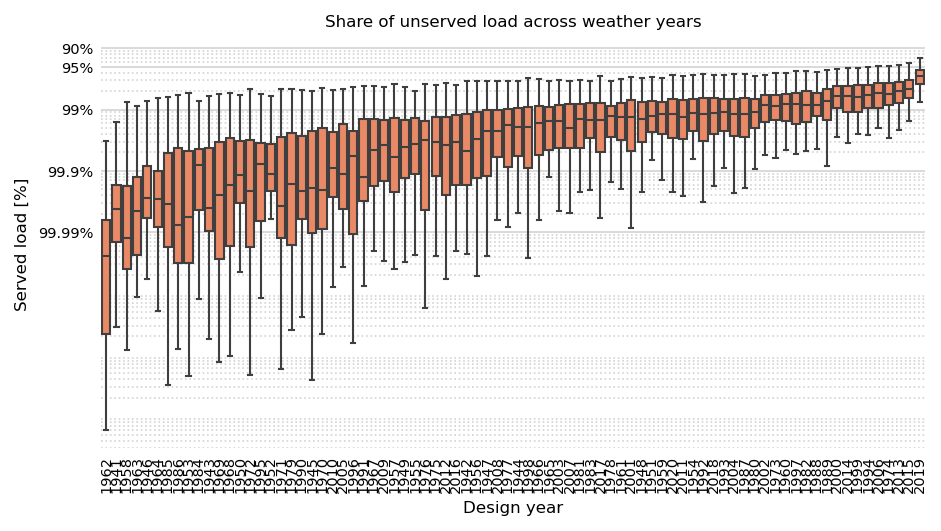

In [45]:
# Boxplot of share of unserved load, remove most outliers
# Reorder index and columns
share_unserved_sorted_index = share_unserved.mean(axis="columns").sort_values().index
resort_share_unserved = share_unserved.loc[share_unserved_sorted_index, share_unserved_sorted_index]
# Plot boxplot for share of unserved load
fig, ax = plt.subplots(figsize=(18 * cm, 9 * cm))
sns.boxplot(data=resort_share_unserved.T, ax=ax, color="coral", showfliers=False, log_scale=True)
# Rotate x-axis labels
ax.set_xlabel("Design year", fontsize=8)
ax.set_ylabel("Served load [%]", fontsize=8)
ax.set_title("Share of unserved load across weather years", fontsize=8)
plt.xticks(rotation=90)

# Change ticks to represent reliability, i.e. 95% (at 5e1), 99%, 99.9%, 99.99%.
ax.set_yticks([10, 5, 1, 0.1, 0.01])
ax.set_yticklabels(["90%", "95%", "99%", "99.9%", "99.99%"])

# Aesthetics: add grid, despine, add y-axis limits
sns.despine(ax=ax, left=True, bottom=True)
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_reliability.pdf", bbox_inches='tight', dpi=300)


## S25: Reliability across design years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

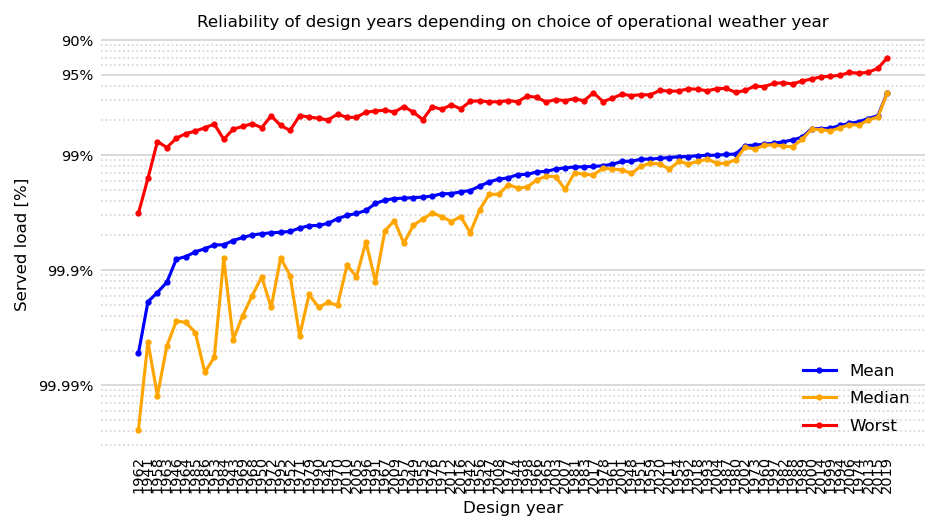

In [46]:
# share of unserved load, remove most outliers
fig, ax = plt.subplots(figsize=(18 * cm, 9 * cm))

# Reorder share_unserved according to share_unserved.mean(axis="columns").sort_values().index

# Only plot mean and median and max on log scale
ax.set_yscale("log")
ax.plot(resort_share_unserved.mean(axis="columns"), label="Mean", color="blue", marker='o', markersize=2)
ax.plot(resort_share_unserved.median(axis="columns"), label="Median", color="orange", marker='o', markersize=2)
ax.plot(resort_share_unserved.max(axis="columns"), label="Worst", color="red", marker='o', markersize=2)


# Rotate x-axis labels
ax.set_xlabel("Design year", fontsize=8)
ax.set_ylabel("Served load [%]", fontsize=8)
ax.set_title("Reliability of design years depending on choice of operational weather year", fontsize=8)
plt.xticks(rotation=90)


# Change ticks to represent reliability, i.e. 95% (at 5e-1), 99%, 99.9%, 99.99%.
ax.set_yticks([10, 5, 1, 0.1, 0.01])
ax.set_yticklabels(["90%", "95%", "99%", "99.9%", "99.99%"])
# Show all x ticks.
ax.set_xticks(share_unserved.index)
# Add grid
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')

# Aesthetics
sns.despine(ax=ax, left=True, bottom=True)
# Add legend
ax.legend(loc="lower right", fontsize=8, frameon=False, labelspacing=0.75)
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_max_median_reliability.pdf", bbox_inches='tight', dpi=300)

## S26: Unserved load across design years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


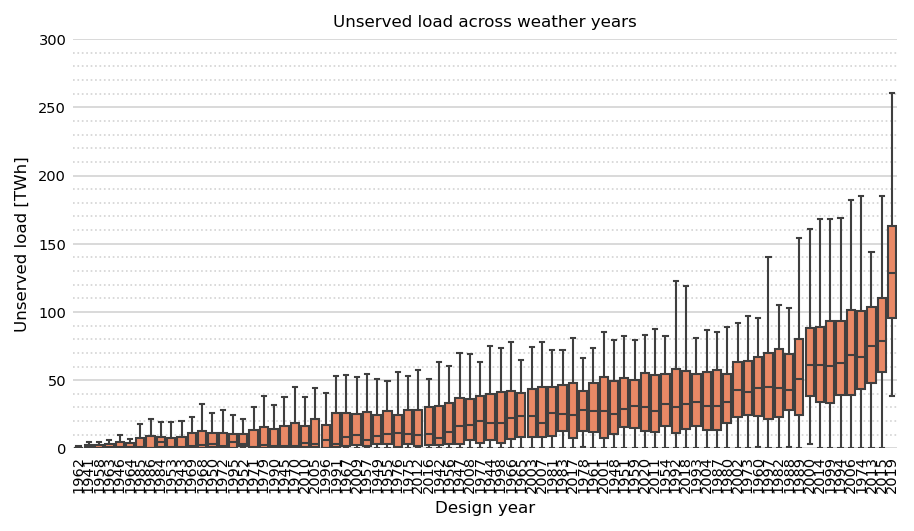

In [47]:
# # Boxplot of unserved load, remove most outliers
unserved_sorted_index = unserved.mean(axis="columns").sort_values().index
resort_unserved = unserved.loc[unserved_sorted_index, unserved_sorted_index]

# # also reorder columns
# resort_unserved = resort_unserved[list([str(r) for r in unserved_sorted_index])]


fig, ax = plt.subplots(figsize=(18 * cm, 9 * cm))
sns.boxplot(data=(resort_unserved.T / 1e3), ax=ax, color = "coral", showfliers=False)
# Rotate x-axis labels
ax.set_xlabel("Design year", fontsize=8)
ax.set_ylabel("Unserved load [TWh]", fontsize=8)
ax.set_title("Unserved load across weather years", fontsize=8)
# Reorder x ticks according to unserved_sorted_index
plt.xticks(rotation=90)

# Aesthetics: add grid, despine, add y-axis limits
sns.despine(ax=ax, left=True, bottom=True)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.set_ylim(0, 300)
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_unserved_design.pdf", bbox_inches='tight', dpi=300)


## S27: Unserved load across operational years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


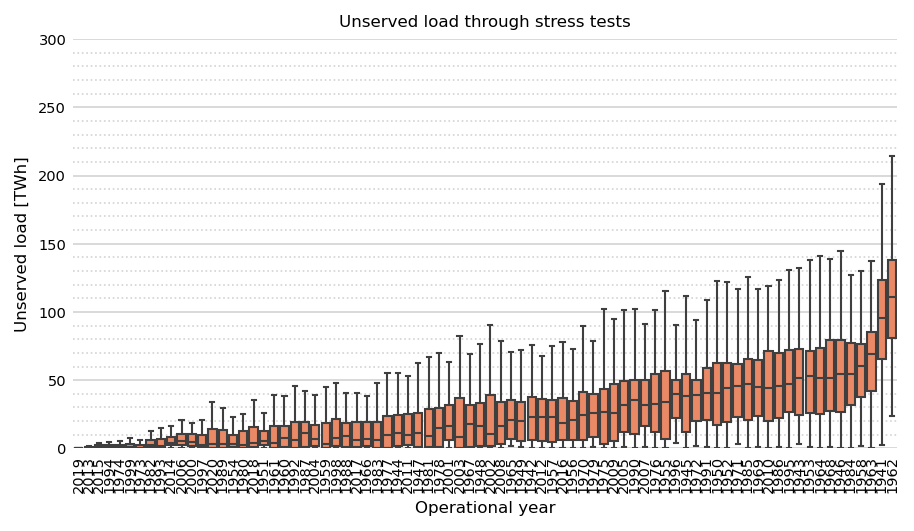

In [48]:
# # Boxplot of unserved load, remove most outliers, stress test
op_unserved_sorted_index = unserved.mean(axis="index").sort_values().index
resort_op_unserved = unserved.loc[op_unserved_sorted_index, op_unserved_sorted_index]

# # also reorder columns
# resort_unserved = resort_unserved[list([str(r) for r in unserved_sorted_index])]


fig, ax = plt.subplots(figsize=(18* cm, 9 * cm))
sns.boxplot(data=(resort_op_unserved / 1e3), ax=ax, color = "coral", showfliers=False)
# Rotate x-axis labels
ax.set_xlabel("Operational year", fontsize=8)
ax.set_ylabel("Unserved load [TWh]", fontsize=8)
ax.set_title("Unserved load through stress tests", fontsize=8)
# Reorder x ticks according to unserved_sorted_index
plt.xticks(rotation=90)

# Aesthetics: add grid, despine, add y-axis limits
sns.despine(ax=ax, left=True, bottom=True)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.set_ylim(0, 300)
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_unserved_operational.pdf", bbox_inches='tight', dpi=300)


## S28: Max load shedding across design years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


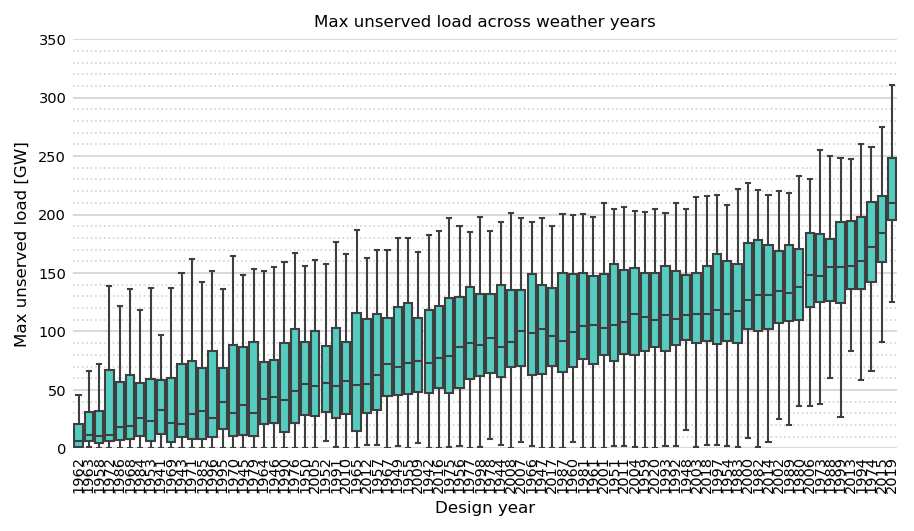

In [49]:
# Boxplot of max unserved load, remove most outliers


# Reorder index and columns
max_unserved_sorted_index = max_unserved.mean(axis="columns").sort_values().index
resort_max_unserved = max_unserved.loc[max_unserved_sorted_index, max_unserved_sorted_index]


# Plot boxplot for max unserved load
fig, ax = plt.subplots(figsize=(18 * cm, 9 * cm))
sns.boxplot(data=resort_max_unserved.T, ax=ax, color = "turquoise", showfliers=False)
# Rotate x-axis labels
ax.set_xlabel("Design year", fontsize=8)
ax.set_ylabel("Max unserved load [GW]", fontsize=8)
ax.set_title("Max unserved load across weather years", fontsize=8)
plt.xticks(rotation=90)

# Aesthetics: add grid, despine, add y-axis limits
sns.despine(ax=ax, left=True, bottom=True)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.set_ylim(0, 350)
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_shedding_design.pdf", bbox_inches='tight', dpi=300)




## S29: Max load shedding across operational years

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


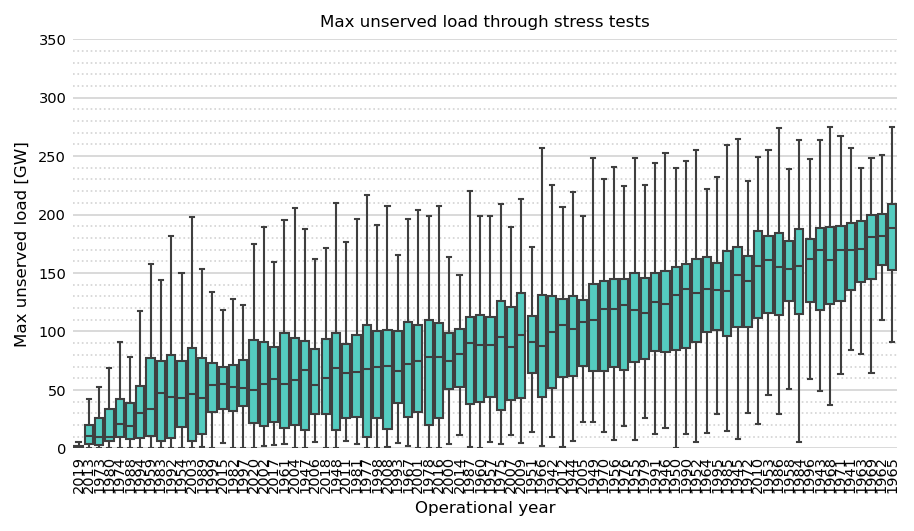

In [50]:
# Boxplot of max unserved load, remove most outliers (OPERATIONAL YEARS)


# Reorder index and columns
op_max_unserved_sorted_index = max_unserved.mean(axis="index").sort_values().index
resort_op_max_unserved = max_unserved.loc[op_max_unserved_sorted_index, op_max_unserved_sorted_index]


# Plot boxplot for max unserved load
fig, ax = plt.subplots(figsize=(18 * cm, 9 * cm))
sns.boxplot(data=resort_op_max_unserved, ax=ax, color = "turquoise", showfliers=False)
# Rotate x-axis labels
ax.set_xlabel("Operational year", fontsize=8)
ax.set_ylabel("Max unserved load [GW]", fontsize=8)
ax.set_title("Max unserved load through stress tests", fontsize=8)
plt.xticks(rotation=90)

# Aesthetics: add grid, despine, add y-axis limits
sns.despine(ax=ax, left=True, bottom=True)
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.grid(color='lightgray', linestyle='solid', which='major')
ax.yaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.set_ylim(0, 350)
ax.tick_params(axis='both', which='both', length=0, labelsize=7)

plt.savefig("paper_plots/supp_mat/years_shedding_operational.pdf", bbox_inches='tight', dpi=300)


